In [2]:
## import libraries
import numpy as np
import pandas as pd
import utils
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from math import sqrt
from pybaseball import statcast
from pybaseball import playerid_reverse_lookup
from bs4 import BeautifulSoup
import requests
import lxml
import datetime
import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from pybaseball import batting_stats_bref
from pybaseball import statcast_batter_expected_stats
from pybaseball import statcast_pitcher_expected_stats
from pybaseball import pitching_stats
from pybaseball import cache
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
from scipy.optimize import minimize
import pulp
from pulp import *
import datetime
import random
import pickle
import cProfile
import time
# import logistic regression and accuracy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot

import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None
# cache.enable()

optional = ''

In [3]:
# functions



# get today's date formatted as yyyy-mm-dd
def get_todays_date():
  # get the current date
  today = datetime.date.today()
  # format the date as yyyy-mm-dd
  date = today.strftime('%Y-%m-%d')
  # return the date
  return date

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


def get_starters(date):
  # url for the website
  url = 'https://www.fangraphs.com/livescoreboard.aspx?date=' + date
  # get the website with bs
  response = requests.get(url)
  soup = BeautifulSoup(response.text, 'html.parser')
  tables = soup.find_all('table', class_='lineup')

  starting = []
  for table in tables:
    row = table.find_all('tr')
    for r in row:
      col = r.find_all('td')
      for c in col:
        a = c.find_all('a')
        if len(a) > 0:
          for i in a:
            name = i.text
            # change names which are not in the correct format
            if name == 'Cedric Mullins II':
              starting.append('Cedric Mullins')
            elif name == 'Mike Siani':
              starting.append('Michael Siani')
            elif name == 'Enrique Hernandez':
              starting.append('Kike Hernandez')
            elif name == 'J.J. Bleday':
              starting.append('JJ Bleday')
            elif name == 'D.J. Stewart':
              starting.append('DJ Stewart')
            else:
              starting.append(name)


  starting_df = pd.DataFrame(starting)
  return starting_df

            
def calculate_batting_fantasy_points(row):
  points = 0
  if row['events']=='single' or row['events'] == 'walk':
    points = points + 3
  elif row['events']=='double':
    points = points + 5
  elif row['events']=='triple':
    points = points + 8
  elif row['events']=='home_run':
    points = points + 10

  points = points + 4 * (row['post_bat_score']- row['bat_score'])

  return points

def calculate_pitching_fantasy_points(row):
  points = 0
  if row['events']=='strikeout':
    points = points + 2.75
  elif row['events']=='double_play' or row['events']=='grounded_into_double_play':
    points = points + 1.5
  elif row['events']=='strikeout_double_play' or row['events']=='strikeout_double_play':
    points = points + 3.5
  elif row['events']=='triple_play':
    points = points + 2.25
  elif row['events']=='single' or row['events'] == 'walk' or row['events'] == 'hit_by_pitch' or row['events'] == 'double' or row['events'] == 'triple' or row['events'] == 'home_run':
    points = points - .6
  else:
    points = points + .75

  points = points - 2 * (row['post_bat_score']- row['bat_score'])
  return points

def total_ball_movement(row):
  # return calculation if is a number else return 0
  x = row['pfx_x']
  z = row['pfx_z']
  if np.isnan(x):
    x = 0
  if np.isnan(z):
    z = 0
  total_movement = sqrt(x**2 + z**2)
  return total_movement

def batter_adjusted_plate_x(row):
  if row['stand'] == 'R':
    return row['plate_x']
  else:
    return -row['plate_x']

# sum batter stats per team for each game
def team_batters_games(df):
  df['team'] = df.apply(team, axis=1)
  team_batters = df.groupby(['game_pk', 'team'])['batter_fp'].sum().reset_index()
  return team_batters
    
# determine team based on inning_topbot
def team(row):
  if row['inning_topbot'] == 'Top':
    return row['away_team']
  else:
    return row['home_team']
  
# sum pitcher stats per team for each game
def team_pitchers_games(df):
  df['team'] = df.apply(team, axis=1)
  team_pitchers = df.groupby(['game_pk', 'team', 'player_name'])['pitcher_fp'].sum().reset_index()
  # get batters faced per pitcher
  batters_faced = df.groupby(['game_pk', 'team', 'player_name'])['batter'].count().reset_index()
  # merge the two dataframes
  team_pitchers = pd.merge(team_pitchers, batters_faced, on=['game_pk', 'team', 'player_name'])
  # for each game, select the pitcher with the most batters faced
  team_pitchers = team_pitchers.sort_values(by=['game_pk', 'batter'], ascending=False).drop_duplicates(subset=['game_pk', 'team'])
  return team_pitchers

# batter fantasy points by game
def batter_fp(df):
  df['batter_fp'] = df.apply(calculate_batting_fantasy_points, axis=1)

  # return points
  batter_game_fp = df.groupby(['game_pk', 'batter'])['batter_fp'].sum().reset_index()
  return batter_game_fp

# get number of plate appearances for each batter
def get_plate_appearances(df):
  plate_appearances = df.groupby(['batter'])['batter'].count().reset_index(name='pa')
  return plate_appearances

# filter the df to only the last x days
def last_x_days(df, x):
  # get the current date
  today = datetime.date.today()
  # get the date x days ago
  x_days_ago = today - datetime.timedelta(days=x)
  # convert to date
  x_days_ago = x_days_ago.strftime('%Y-%m-%d')
  # filter the df to only the last x days
  df = df[df['game_date'] > x_days_ago]
  return df

# fix player names to remove latin characters
def fix_player_names(df, column_name):
  df.loc[:, column_name] = df.loc[:, column_name].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
  # remove suffixes
  df = remove_suffixes(df, column_name)
  return df

# fix players names to move first name to the front and remove commas
def fix_player_names2(df, column_name):
  df[column_name] = df[column_name].str.split(',').str[1] + ' ' + df[column_name].str.split(',').str[0]
  return df

# get the frequency that a player has a stat between two values
def player_stat_frequency(df, player_name, column_name, lower, upper, is_batter=True):
  # filter the df to the selected player depending on if they are a batter or pitcher
  if is_batter:
    df = df[df['batter'] == player_name]
  else:
    df = df[df['player_name'] == player_name]

  # fix for when tyring to divide by zero
  if df.shape[0] == 0:
    return 0
  # find how often column name is between lower and upper
  freq = df[(df[column_name] >= lower) & (df[column_name] <= upper)].shape[0] / df.shape[0]
  return freq

# reformatting for merge
def convert_to_player_name(row):
  name = row['Name']
  # handle case for names with two spaces
  if len(name.split(' ')) > 2:
    return  name.split(' ')[1] + ' ' + name.split(' ')[2] + ', ' + name.split(' ')[0]
  else:
    return name.split(' ')[1] + ', ' + name.split(' ')[0]
    
# get data before date x
def data_before_date(df, y, m, d):
  x = y + "-" + m + "-" + d
  # filter the df to only the last x days
  df = df[df['game_date'] < x]
  return df


def get_batter_game_fp(pregame_info):
    # batter game fp
    batter_game_fp = batter_fp(pregame_info) # replaced batter_recent_info with df

    # get plate appearances for each batter
    plate_appearances = get_plate_appearances(pregame_info) # replaced batter_recent_info with df

    # get batter names
    batter_ids = batter_game_fp['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

    # rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge batter names with batter game fp and plate_appearances
    batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
    batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

    # filter out batters with less than 14 plate appearances
    batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

    # get 25th and 75th percentile outcomes for batter_fp for batters
    batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
    batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
    batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
    batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
    batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)
    return batter_game_fp



def get_pitcher_exp(pregame_info):
    # get all qualified pitchers in 2024
    pitcher_exp = pitching_stats(2024, qual=10)
    pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

    # apply convert_to_player_name to Name column
    pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

    # get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
    pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_speed', 100, 150, is_batter=False), axis=1)
    pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(pregame_info, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)
    return pitcher_exp


def get_batter_exp(pregame_info):
    # get all of this season's expected batting data so far
    batter_exp = statcast_batter_expected_stats(2024, 20)

    batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
    batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
    # rename first column to batter_name and player_id to batter
    batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
    batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

    # get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
    batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_speed', 100, 150), axis=1)
    batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(pregame_info, row['batter'], 'launch_angle', 25, 31.25), axis=1)
    return batter_exp


def get_pregame_batting_order(pregame_info):
    # get only the last game for each team
    #pregame_info = pregame_info.groupby(['game_pk', 'team']).apply(lambda x: x.iloc[-1]).reset_index(drop=True)
    # get only the first at bat for each batter per game
    pregame_batting_order = pregame_info.sort_values(by=['game_pk', 'at_bat_number'])
    pregame_batting_order = pregame_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    pregame_batting_order["batting_order"] = pregame_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    pregame_batting_order = pregame_batting_order[pregame_batting_order['batting_order'] <= 9]
    return pregame_batting_order

def trim(col):
    return col.str.strip()

def remove_suffixes(df, col):
    # df[col] = df[col].str.replace(' Jr.', '')
    # df[col] = df[col].str.replace(' Sr.', '')
    # df[col] = df[col].str.replace(' II', '')
    # df[col] = df[col].str.replace(' III', '')
    # df[col] = df[col].str.replace(' IV', '')

    #do the above without chained indexing
    df.loc[:, col] = df.loc[:, col].str.replace(' Jr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' Sr.', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' III', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' II', '')
    df.loc[:, col] = df.loc[:, col].str.replace(' IV', '')
    return df

def adjust_player_name(row):
  first_name = row['name_first']
  last_name = row['name_last']
  # fix names which are not in the correct format
  if last_name == 'vogelbach':
    return 'dan vogelbach'
  elif last_name == 'siani':
    return 'michael siani'
  elif first_name == 'j. d.':
    return 'j.d. martinez'
  elif row['batter_name'] == 'Michael A. Taylor':
    return 'michael taylor'

  return row['batter_name']

def filter_from_last_game_pks(df, last_game_pks):
  # remove rows in which team and game_pks pairs are not in last_game_pks
  for index, row in df.iterrows():
    if row['game_pk'] not in last_game_pks['game_pk']:
      df = df.drop(index)
    elif row['team'] not in last_game_pks['team']:
      df = df.drop(index)
    elif not(last_game_pks['team'].index_of(row['team']) == last_game_pks['game_pk'].index_of(row['game_pk'])):
      df = df.drop(index)
  return df

In [4]:
# get base df

# Get all Statcast data from 2024
df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# Only include events
df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
df = fix_player_names(df, 'player_name')

# get more info
df['pitcher_fp'] = df.apply(lambda row: calculate_pitching_fantasy_points(row), axis=1)
df['batter_fp'] = df.apply(lambda row: calculate_batting_fantasy_points(row), axis=1)
df['total_ball_movement'] = df.apply(lambda row: total_ball_movement(row), axis=1)
df['batter_adjusted_plate_x'] = df.apply(lambda row: batter_adjusted_plate_x(row), axis=1)

# get team batters
team_batters = team_batters_games(df)

# get team pitchers
team_pitchers = team_pitchers_games(df)

# get game_pks and game_dates
game_info = df[['game_pk', 'game_date', 'away_team', 'home_team']].drop_duplicates()

# combine team batters and team pitchers
team_stats = pd.merge(team_batters, team_pitchers, on=['game_pk', 'team'])
# merge with game info
team_stats = pd.merge(team_stats, game_info, on='game_pk')
team_stats.head()

# get 75th percentile outcomes for batter_fp and pitcher_fp for pitchers and teams
team_stats['batter_fp'] = team_stats['batter_fp'].astype(float)
team_stats['pitcher_fp'] = team_stats['pitcher_fp'].astype(float)

# use a dataframe for team-based stats that only uses data from the last 10 days
team_info_df = last_x_days(team_stats, 10)
team_info_df['team_fp_75'] = team_info_df.groupby('team')['batter_fp'].transform(lambda x: x.quantile(.75))
team_info_df['opp_pitcher_fp_75'] = team_info_df.groupby('team')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_info_df['team_fp_75'] = team_info_df['team_fp_75'].fillna(0)
team_info_df['opp_pitcher_fp_75'] = team_info_df['opp_pitcher_fp_75'].fillna(0)

# pitchers can have full season stats
team_stats['pitcher_fp_75'] = team_stats.groupby('player_name')['pitcher_fp'].transform(lambda x: x.quantile(.75))
team_stats['opp_team_fp_75'] = team_stats.groupby('player_name')['batter_fp'].transform(lambda x: x.quantile(.75))
team_stats['pitcher_fp_75'] = team_stats['pitcher_fp_75'].fillna(0)
team_stats['opp_team_fp_75'] = team_stats['opp_team_fp_75'].fillna(0)

# separate teams and pitchers 75th percentiles, and drop duplicates
pitcher_outliers = team_stats[['player_name', 'pitcher_fp_75', 'opp_team_fp_75']].drop_duplicates()
pitcher_outliers = fix_player_names(pitcher_outliers, 'player_name')
team_outliers = team_info_df[['team', 'team_fp_75', 'opp_pitcher_fp_75']].drop_duplicates()

# change team from AZ to ARI and WSH to WAS
team_outliers['team'] = team_outliers['team'].replace({'AZ': 'ARI', 'WSH': 'WAS'})

#pitcher_outliers.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_outliers.csv', index=False)
team_outliers.to_csv('C:\\Users\\jorda\\Downloads\\team_outliers.csv', index=False)

# use last_x_days to filter df for recency
# batter_recent_info = last_x_days(df, 10)

# finding recency bias to be problematic, so we will use all data

# batter game fp
batter_game_fp = batter_fp(df) # replaced batter_recent_info with df

# get plate appearances for each batter
plate_appearances = get_plate_appearances(df) # replaced batter_recent_info with df

# get batter names
batter_ids = batter_game_fp['batter'].unique()
batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')

# rename key_mlbam to batter; capitalize first letter of  combine name_first and name_last, then combine name_first and name_last to batter_name
batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

# merge batter names with batter game fp and plate_appearances
batter_game_fp = pd.merge(batter_game_fp, batter_name_id_pairs, on='batter')
batter_game_fp = pd.merge(batter_game_fp, plate_appearances, on='batter')

# filter out batters with less than 14 plate appearances
batter_game_fp = batter_game_fp[batter_game_fp['pa'] >= 14]

# get 25th and 75th percentile outcomes for batter_fp for batters
batter_game_fp['batter_fp'] = batter_game_fp['batter_fp'].astype(float)
batter_game_fp['batter_fp_25'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.25))
batter_game_fp['batter_fp_25'] = batter_game_fp['batter_fp_25'].fillna(0)
batter_game_fp['batter_fp_75'] = batter_game_fp.groupby('batter')['batter_fp'].transform(lambda x: x.quantile(.75))
batter_game_fp['batter_fp_75'] = batter_game_fp['batter_fp_75'].fillna(0)

# select only batter_name and batter_fp_75 and drop duplicates
batter_outliers = batter_game_fp[['batter_name', 'batter_fp_25', 'batter_fp_75', 'batter']].drop_duplicates()
# batter_outliers.to_csv('C:\\Users\\jorda\\Downloads\\batter_outliers.csv', index=False)



# get data for all qualified pitchers in 2024
pitcher_exp = pitching_stats(2024, qual=10)
pitcher_exp = pitcher_exp[['Name', 'WHIP', 'Stuff+', 'Location+', 'Pitching+']]

# apply convert_to_player_name to Name column
pitcher_exp['player_name'] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

# get pitcher frequency of plate_z between 2 and 3, release_speed between 90 and 95, and release_spin_rate between 2090 and 2470
pitcher_exp['hr_friendly_launch_speed_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_speed', 100, 109, is_batter=False), axis=1)
pitcher_exp['hr_friendly_launch_angle_pitcher'] = pitcher_exp.apply(lambda row: player_stat_frequency(df, row['player_name'], 'launch_angle', 25, 31.25, is_batter=False), axis=1)


# merge with pitcher_outliers
pitcher_exp = pd.merge(pitcher_exp, pitcher_outliers, on='player_name')
pitcher_exp.to_csv('C:\\Users\\jorda\\Downloads\\pitcher_exp.csv', index=False)


# get all of this season's expected batting data so far
batter_exp = statcast_batter_expected_stats(2024)
batter_exp = fix_player_names(batter_exp, 'last_name, first_name')
batter_exp = fix_player_names2(batter_exp, 'last_name, first_name')
# rename first column to batter_name and player_id to batter
batter_exp = batter_exp.rename(columns={batter_exp.columns[0]: 'batter_name'})
batter_exp = batter_exp.rename(columns={'player_id': 'batter'})

# get batter frequency of launch speed between 100 and 109 and launch angle between 25 and 31.25
batter_exp['hr_friendly_launch_speed_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_speed', 100, 150), axis=1)
batter_exp['hr_friendly_launch_angle_freq'] = batter_exp.apply(lambda row: player_stat_frequency(df, row['batter'], 'launch_angle', 25, 31.25), axis=1)
# merge with batter_outliers

batter_exp = pd.merge(batter_exp, batter_outliers, on='batter')
batter_exp.to_csv('C:\\Users\\jorda\\Downloads\\batter_exp.csv', index=False)

# summarize df
batter_summary = batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()

# get only the first at bat for each batter per game
batting_order = df.sort_values(by=['game_pk', 'at_bat_number'])
batting_order = batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
batting_order["batting_order"] = batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
batting_order = batting_order[batting_order['batting_order'] <= 9]

pitcher_exp["player_name"] = pitcher_exp.apply(lambda row: convert_to_player_name(row), axis=1)

model_data = pd.merge(batter_summary, batting_order, on=['game_pk', 'batter'])
model_data = pd.merge(model_data, batter_exp, on='batter')
model_data = pd.merge(model_data, pitcher_exp, on='player_name')

pitcher_summary = df.groupby(['game_pk', 'player_name'])['pitcher_fp'].sum().reset_index()
model_data = pd.merge(model_data, pitcher_summary, on=['game_pk', 'player_name'])

This is a large query, it may take a moment to complete


100%|██████████| 92/92 [00:19<00:00,  4.80it/s]


In [5]:
# get mean pitch coordinates
# mean_pitch_coordinates = df.groupby(['pitcher', 'player_name'])[['plate_x', 'plate_z', 'batter_adjusted_plate_x']].mean()
# mean_pitch_coordinates.rename(columns={'plate_x':'mean_pitcher_plate_x', 'plate_z':'mean_pitcher_plate_z', 'batter_adjusted_plate_x':'mean_pitcher_batter_adjusted_plate_x'}, inplace=True)
# mean_pitch_coordinates.to_csv("C:\\Users\\jorda\\Downloads\\pitch_coordinates.csv")
# mean_pitch_coordinates.head()
# df = statcast(start_dt='2024-03-28', end_dt=get_todays_date())

# # Only include events
# df = df.dropna(subset=['events', 'pitch_type', 'pfx_x', 'pfx_z', 'plate_x', 'stand', 'game_date', 'game_pk', 'at_bat_number', 'inning_topbot', 'away_team', 'home_team', 'post_bat_score', 'bat_score'])
# df = fix_player_names(df, 'player_name')


Analysis of Past Slates

In [254]:
# get draftkings salaries based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLBMMDDYYYY.csv"
def get_pregame_info(df, year, month, day):
    pregame_info = data_before_date(df, year, month, day)

    pregame_batter_game_fp = get_batter_game_fp(pregame_info)
    pregame_pitcher_exp = get_pitcher_exp(pregame_info)
    pregame_batter_exp = get_batter_exp(pregame_info)

    # summarize df
    pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


    pregame_batting_order = get_pregame_batting_order(pregame_info)

    # get batter, game_pk, and batting order from pregame_batting_order
    pregame_batting_order = get_pregame_batting_order(pregame_info)
    pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

    # merge all pregame data
    pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'], how='left')
    pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter', how='left')

    pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name', how='left')

    # add pitcher_fp to pregame_data
    pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'], how='left')

    pregame_data = fix_player_names(pregame_data, 'batter_name')
    pregame_data = fix_player_names(pregame_data, 'player_name')

    pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
    pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
    # merge the two dataframes
    pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name', how='left')
    # add a column for the change in batting order
    pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']

    # drop columns with missing values
    pregame_data = pregame_data.dropna()

    return pregame_data

def get_dk_salaries(year, month, day, optional=""):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\DKSalariesMLB" + month + day + year + optional + ".csv"
    print(string)
    salaries = pd.read_csv(string)
    return salaries

# get contest standings based on the date from "C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandingsMMDDYYYY.csv"
def get_contest_standings(year, month, day):
    string = "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\MLBContestStandings" + month + day + year + ".csv"
    print(string)
    contest_data = pd.read_csv(string)
    return contest_data

def get_contest_results(contest_data):
    contest_player_results = contest_data[['Player', '%Drafted', 'FPTS']]
    # drop nas
    contest_player_results = contest_player_results.dropna()
    # convert %Drafted to a float
    contest_player_results['%Drafted'] = contest_player_results['%Drafted'].str.replace('%', '').astype(float)
    # convert FPTS to a float
    contest_player_results['FPTS'] = contest_player_results['FPTS'].astype(float)
    # fix player names
    contest_player_results = fix_player_names(contest_player_results, 'Player')
    # remove suffixes
    contest_player_results = remove_suffixes(contest_player_results, 'Player')
    return contest_player_results

def get_leaderboard(contest_data):
    leaderboard = contest_data[['Rank', 'Points', 'Lineup']]
    leaderboard = leaderboard.dropna()
    # convert Points to a float
    leaderboard['Points'] = leaderboard['Points'].astype(float)
    return leaderboard

# get files in folder "C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\" and return their names
def get_files():
    files = []
    for file in os.listdir("C:\\Users\\jorda\\OneDrive\\Desktop\\DFS History\\MLB\\"):
        if file.endswith(".csv"):
            files.append(file)
    return files

In [235]:
pregame_info = data_before_date(df, year, month, day)

pregame_batter_game_fp = get_batter_game_fp(pregame_info)
pregame_pitcher_exp = get_pitcher_exp(pregame_info)
pregame_batter_exp = get_batter_exp(pregame_info)

# summarize df
pregame_batter_summary = pregame_batter_game_fp.groupby(['game_pk','batter'])['batter_fp'].sum().reset_index()


pregame_batting_order = get_pregame_batting_order(pregame_info)

# get batter, game_pk, and batting order from pregame_batting_order
pregame_batting_order = get_pregame_batting_order(pregame_info)
pregame_batting_order = pregame_batting_order[['batter', 'game_pk', 'batting_order', 'player_name']]

# merge all pregame data
pregame_data = pd.merge(pregame_batter_summary, pregame_batting_order, on=['game_pk', 'batter'], how='left')
pregame_data = pd.merge(pregame_data, pregame_batter_exp, on='batter', how='left')

pregame_data = pd.merge(pregame_data, pregame_pitcher_exp, on='player_name', how='left')

# add pitcher_fp to pregame_data
pregame_data = pd.merge(pregame_data, pitcher_summary, on=['game_pk', 'player_name'], how='left')

pregame_data = fix_player_names(pregame_data, 'batter_name')
pregame_data = fix_player_names(pregame_data, 'player_name')

pregame_batter_game_fp_mean = pregame_data[['batter_name', 'batting_order', 'batter_fp']]
pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.groupby('batter_name').mean().reset_index()
pregame_batter_game_fp_mean = pregame_batter_game_fp_mean.rename(columns={'batting_order': 'avg_batting_order', 'batter_fp': 'avg_batter_fp'})
# merge the two dataframes
pregame_data = pd.merge(pregame_data, pregame_batter_game_fp_mean, on='batter_name', how='left')
# add a column for the change in batting order
pregame_data['batting_order_change'] = pregame_data['avg_batting_order'] - pregame_data['batting_order']


In [236]:
#pregame_batter_game_fp[pregame_batter_game_fp['name_last'] == 'albies'] # g2g
#pregame_batter_exp[pregame_batter_exp['batter'] == 645277] # g2g
#pregame_batter_summary[pregame_batter_summary['batter'] == 645277] # g2g
#pregame_data[pregame_data['batter_name'] == 'Matt Olson'] # NOT
#pregame_batting_order[pregame_batting_order['batter'] == 645277] # g2g
# pregame_data[pregame_data['batter_name'].str.contains("Ozzie Albies")] # contains, but is not equal

pregame_data[pregame_data['batter_name'].str.contains("Ozzie Albies")] # contains, but is not equal

,game_pk,batter,batter_fp,batting_order,player_name,batter_name,year,pa,bip,ba,est_ba,est_ba_minus_ba_diff,slg,est_slg,est_slg_minus_slg_diff,woba,est_woba,est_woba_minus_woba_diff,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Name,WHIP,Stuff+,Location+,Pitching+,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,pitcher_fp,avg_batting_order,avg_batter_fp,batting_order_change
83,744844,645277,5.000,1.000,"Parker, Mitchell",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Mitchell Parker,1.080,88.000,100.000,98.000,0.167,0.057,13.350,2.211,7.465,1.211
100,744845,645277,0.000,5.000,"Irvin, Jake",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Jake Irvin,1.120,96.000,105.000,102.000,0.191,0.054,17.900,2.211,7.465,-2.789
160,744848,645277,9.000,1.000,"Gore, MacKenzie",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,MacKenzie Gore,1.320,114.000,100.000,104.000,0.116,0.046,15.700,2.211,7.465,1.211
179,744849,645277,3.000,1.000,"Herz, DJ",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,DJ Herz,1.190,94.000,97.000,98.000,0.162,0.071,13.550,2.211,7.465,1.211
3115,745157,645277,3.000,2.000,"Gibson, Kyle",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Kyle Gibson,1.200,93.000,97.000,94.000,0.162,0.074,3.600,2.211,7.465,0.211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23243,747138,645277,16.000,2.000,"Houser, Adrian",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Adrian Houser,1.570,92.000,100.000,97.000,0.172,0.065,-3.950,2.211,7.465,0.211
23259,747140,645277,0.000,2.000,"Pfaadt, Brandon",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Brandon Pfaadt,1.180,105.000,106.000,106.000,0.160,0.075,12.100,2.211,7.465,0.211
23279,747141,645277,5.000,2.000,"Nelson, Ryne",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,Ryne Nelson,1.640,97.000,105.000,102.000,0.230,0.069,17.000,2.211,7.465,0.211
23301,747142,645277,23.000,2.000,"Teheran, Julio",Ozzie Albies,2024,293,222,0.262,0.252,0.010,0.416,0.386,0.030,0.323,0.306,0.017,0.084,0.061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.800,2.211,7.465,0.211


In [7]:

def compile_data_from_date(df, year, month, day):
    # merge dk salaries with pregame_data by batter_name
    salaries = get_dk_salaries(year, month, day, "")

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # only keep Name and Salary for pitchers
    pitcher_salaries = pitcher_salaries[['Name', 'Salary', 'TeamAbbrev']]
    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name', 'TeamAbbrev':'pitcher_team'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})

    this_day_statcast = statcast(start_dt=year + '-' + month + '-' + day, end_dt=year + '-' + month + '-' + day)
    # set 'team' as home_team if inning_topbot is 'Bot', and away_team if 'Top'
    this_day_statcast['team'] = this_day_statcast.apply(team, axis=1)
    # get only the first at bat for each batter per game
    this_day_batting_order = this_day_statcast.sort_values(by=['game_pk', 'at_bat_number'])
    this_day_batting_order = this_day_batting_order.groupby(['game_pk', 'batter']).apply(lambda x: x.iloc[0]).reset_index(drop=True)
    this_day_batting_order["batting_order"] = this_day_batting_order.groupby(['game_pk', 'team'])['at_bat_number'].rank()
    this_day_batting_order = this_day_batting_order[this_day_batting_order['batting_order'] <= 9]

    # get batter_name for this_day_batting_order
    batter_ids = this_day_batting_order['batter'].unique()
    batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
    batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
    batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

    # merge this_day_batting_order with batter_name_id_pairs
    this_day_batting_order = pd.merge(this_day_batting_order, batter_name_id_pairs, on='batter')

    # get pitcher_name for this_day_batting_order based on player_name
    this_day_batting_order = fix_player_names(this_day_batting_order, 'player_name')
    this_day_batting_order= fix_player_names2(this_day_batting_order, 'player_name')
    # rename player_name to Name
    this_day_batting_order = this_day_batting_order.rename(columns={'player_name': 'Name'})
    # merge with pitcher_salaries
    bo_with_salaries = pd.merge(this_day_batting_order, hitter_salaries)
    # only keep Name, team, batting_order, batter_name, Roster Position, Salary
    bo_with_salaries = bo_with_salaries[['Name', 'team', 'batting_order', 'batter_name', 'Roster Position', 'Salary']]
    bo_with_salaries = bo_with_salaries.rename(columns={'Salary': 'batter_salary'})
    bo_with_salaries = bo_with_salaries.rename(columns={'Name': 'pitcher_name'})
    # trim pitcher_name in bo_with_salaries
    bo_with_salaries['pitcher_name'] = trim(bo_with_salaries['pitcher_name'])
    # merge with pitcher_salaries
    new_merge = pd.merge(bo_with_salaries, pitcher_salaries, on='pitcher_name')


    # use historic data to determine hitter and pitcher quality, with the goal of predicting batter_fp and pitcher_fp
    pregame_data = get_pregame_info(df, year, month, day)

    # get pitcher names, plus WHIP, Pitching+
    pitcher_names = pregame_data[['player_name', 'WHIP', 'Pitching+', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # rename player_name to pitcher_name
    pitcher_names = pitcher_names.rename(columns={'player_name': 'pitcher_name'})
    # fix names
    pitcher_names = fix_player_names(pitcher_names, 'pitcher_name')
    pitcher_names = fix_player_names2(pitcher_names, 'pitcher_name')
    # trim names
    pitcher_names['pitcher_name'] = trim(pitcher_names['pitcher_name'])
    # drop duplicates
    pitcher_names = pitcher_names.drop_duplicates()
    # get batter names, plus 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp'
    batter_names = pregame_data[['batter_name', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'avg_batting_order', 'avg_batter_fp']]
    # trim names
    batter_names['batter_name'] = trim(batter_names['batter_name'])
    # drop duplicates
    batter_names = batter_names.drop_duplicates()

    # merge with new_merge by names to set up predictions
    all_data = pd.merge(new_merge, pitcher_names, on='pitcher_name')
    all_data = pd.merge(all_data, batter_names, on='batter_name')

    # add batting_order_change to df
    all_data['batting_order_change'] = all_data['avg_batting_order'] - all_data['batting_order']

    

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    all_data['batter_fp_pred'] = batter_model.predict(all_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    pitcher_data = all_data[['pitcher_name', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Pitcher Model R2: ', r2)
    # print('Pitcher Model RMSE: ', rmse)

    # need ['teams_in_game_pk', 'is_of', 'team_batter_fp_pred']
    # get teams_in_game_pk
    # teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    # all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size
    teams_in_game_pk = all_data['team'].unique()
    all_data['teams_in_game_pk'] = teams_in_game_pk.size
    # get is_of
    all_data['is_of'] = all_data['Roster Position'].apply(lambda x: 1 if x == 'OF' else 0)
    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby('team')['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on='team')

    # predict pitcher_fp for pitcher_data
    pitcher_data['pitcher_fp_pred'] = pitcher_model.predict(pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # select only pitcher_name and pitcher_fp_pred, then merge with all_data
    pitcher_data = pitcher_data[['pitcher_name', 'pitcher_fp_pred']]
    all_data = pd.merge(all_data, pitcher_data, on='pitcher_name')

    # use leaderboard and results to determine the success of each player
    contest_data = get_contest_standings(year, month, day)
    contest_player_results = get_contest_results(contest_data)
    leaderboard = get_leaderboard(contest_data)

    # Establish payoffs for each player based on their performance as well as their appearance in the leaderboard's top 100
    # get the top 20 lineups
    top_20 = leaderboard.head(20)
    # get all players in the all_data dataframe
    all_players = all_data['batter_name'].unique()
    # get pitchers as well
    pitchers = all_data['pitcher_name'].unique()
    # combine those vectors
    all_players = np.concatenate((all_players, pitchers))

    # enumerate payoffs for placements in the top 20
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]

    # create a dictionary for player payoffs
    player_payoffs = {}

    # for each lineup in top_20, look for each player in all_players and increase their payoff by the corresponding value in payoffs if found
    for index, row in top_20.iterrows():
        lineup = row['Lineup']
        for player in all_players:
            if player in lineup:
                if player in player_payoffs:
                    player_payoffs[player] += payoffs[index]
                else:
                    player_payoffs[player] = payoffs[index]

    # for each player in all_players, if they are not in player_payoffs, set their payoff to 0
    for player in all_players:
        if player not in player_payoffs:
            player_payoffs[player] = 0

    # add player payoffs to all_data
    all_data['payoff'] = all_data['batter_name'].map(player_payoffs)

    # add pitcher payoffs to all_data
    all_data['pitcher_payoff'] = all_data['pitcher_name'].map(player_payoffs)


    # add contest results to all_data
    all_data_with_results = pd.merge(all_data, contest_player_results, left_on='batter_name', right_on='Player', how='left')
    # rename %drafted to batter_drafted and FPTS to batter_fpts
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'batter_drafted', 'FPTS': 'batter_fpts'})
    # drop Player column
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # do the same for pitchers
    all_data_with_results = pd.merge(all_data_with_results, contest_player_results, left_on='pitcher_name', right_on='Player', how='left')
    all_data_with_results = all_data_with_results.rename(columns={'%Drafted': 'pitcher_drafted', 'FPTS': 'pitcher_fpts'})
    all_data_with_results = all_data_with_results.drop(columns=['Player'])

    # divide payoff and pitcher_payoff by (leaderboard_size * percent_drafted) to get payoff per usage
    leaderboard_size = leaderboard.shape[0]
    all_data_with_results['payoff'] = all_data_with_results['payoff'] / (leaderboard_size * all_data_with_results['batter_drafted']/100)
    all_data_with_results['pitcher_payoff'] = all_data_with_results['pitcher_payoff'] / (leaderboard_size * all_data_with_results['pitcher_drafted']/100)

    # get mean drafted % by team for pitchers
    team_pitcher_drafted = all_data_with_results.groupby('team')['pitcher_drafted'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted': 'opp_pitcher_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_pitcher_drafted, on='team')

    # get mean drafted % by pitcher_team for batters
    team_batter_drafted = all_data_with_results.groupby('pitcher_team')['batter_drafted'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted': 'opp_batter_drafted_mean'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_drafted, on='pitcher_team')

    # add a column for team_batter_fp_pred
    team_batter_fp_pred = all_data_with_results.groupby('team')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data_with_results = pd.merge(all_data_with_results, team_batter_fp_pred, on='team')
    
    # X = all_data_with_results[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']]
    # y = all_data_with_results['batter_drafted']
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # # build a linear regression model to predict the ownership of each batter
    # model_batter_drafted = LinearRegression()
    # model_batter_drafted.fit(X_train, y_train)
    # y_pred = model_batter_drafted.predict(X_test)
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Ownership Model R2: ', r2)
    # print('Ownership Model RMSE: ', rmse)

    return all_data_with_results


def get_opposing_team(team, game_info):
    # if game info includes Postponed or game_info dtype is float return None
    if game_info == 'Postponed':
        return None
    if type(game_info) == float:
        return None
    # get the opposing team from the game_info
    matchup = game_info.split(' ')[0]
    teams = matchup.split('@')
    if teams[0] == team:
        return teams[1]
    else:
        return teams[0]


In [8]:
def get_all_data_from_draftkings():
    # run compile_data_from_date for all dates and combine the results into a single dataframe
    all_data = pd.DataFrame()
    files = get_files()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            
            all_data = pd.concat([all_data, compile_data_from_date(df, y, m, d)])

    # drop NaNs
    all_data = all_data.dropna()
    # add a column with value 1 if Roster Position contains OF or /
    all_data['is_of'] = all_data['Roster Position'].str.contains('OF|/').astype(int)

    # save all_data to csv in case of loss
    all_data.to_csv('C:\\Users\\jorda\\Downloads\\all_data.csv', index=False)


Below, use to get all old contest data; should not be run more than once per day as all data can be read from CSV

In [9]:
# uncomment the line below to get all data from DraftKings
# get_all_data_from_draftkings()

In [10]:
def get_all_data_plus_team_batter_fp_pred():
    # read from all_data to save time
    all_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_data.csv')

    # get team_batter_fp_pred
    team_batter_fp_pred = all_data.groupby(['team', 'pitcher_name'])['batter_fp_pred'].mean().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_data = pd.merge(all_data, team_batter_fp_pred, on=['team', 'pitcher_name'])

    # multiply by 9 for team_batter_fp_pred
    all_data['team_batter_fp_pred'] = all_data['team_batter_fp_pred'] * 9
    return all_data

all_data = get_all_data_plus_team_batter_fp_pred()


Batter Drafted % Linear Regression model

In [11]:
# model batter_drafted from all_data
X = all_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of', 'team_batter_fp_pred']]
y = all_data['batter_drafted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build a linear regression model to predict the ownership of each batter
model_batter_drafted = LinearRegression()
model_batter_drafted.fit(X_train, y_train)
y_pred = model_batter_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Ownership Model R2: ', r2)
print('Ownership Model RMSE: ', rmse)


Ownership Model R2:  0.44289138520045235
Ownership Model RMSE:  4.040197290698783


In [12]:
def add_batter_ownership(all_data=all_data, model_batter_drafted=model_batter_drafted, X=X):
    # create a copy of all_data and add the predicted ownership to it
    all_data_with_ownership = all_data.copy()
    all_data_with_ownership['batter_drafted_pred'] = model_batter_drafted.predict(X)
    all_data_with_ownership['batter_drafted_pred'] = all_data_with_ownership['batter_drafted_pred']
    all_data_with_ownership.head()
    return all_data_with_ownership

all_data_with_ownership = add_batter_ownership()

In [13]:
# reduce df to pitcher name, batter_salary, pitcher_salary, WHIP, Pitching+, team, pitcher_fp_pred, pitcher_drafted, team_batter_fp_pred, and teams_in_game_pk; get sum of batter_salary and mean of everything else
pitcher_data = all_data_with_ownership[['pitcher_name', 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'team', 'pitcher_fp_pred', 'pitcher_drafted', 'team_batter_fp_pred', 'teams_in_game_pk']]
pitcher_data = pitcher_data.groupby(['pitcher_name', 'pitcher_drafted']).agg({'batter_salary': 'sum', 'pitcher_salary': 'mean', 'WHIP': 'mean', 'Pitching+': 'mean', 'pitcher_fp_pred': 'mean', 'team_batter_fp_pred': 'mean', 'teams_in_game_pk': 'mean'}).reset_index()
# merge this with unique pitcher_name and pitcher_drafted
pitcher_data.head()

,pitcher_name,pitcher_drafted,batter_salary,pitcher_salary,WHIP,Pitching+,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk
0,Aaron Civale,0.81,34500,7800.0,1.39,101.0,9.323685,75.450177,20.0
1,Aaron Civale,1.95,33300,7200.0,1.39,101.0,10.920535,72.342391,26.0
2,Adam Mazur,1.29,22300,7700.0,2.05,95.0,1.121708,90.314884,14.0
3,Albert Suarez,1.56,33800,7400.0,1.20,95.0,10.738687,71.081774,20.0
4,Albert Suarez,2.13,17400,7600.0,1.20,95.0,15.968549,52.959284,26.0


In [14]:
# linear regression model to predict pitcher_drafted
# rename batter_salary to team_batter_salary
pitcher_data = pitcher_data.rename(columns={'batter_salary': 'team_batter_salary'})
X = pitcher_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']]
y = pitcher_data['pitcher_drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model_pitcher_drafted = LinearRegression()
model_pitcher_drafted.fit(X_train, y_train)
y_pred = model_pitcher_drafted.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Ownership Model R2: ', r2)
print('Pitcher Ownership Model RMSE: ', rmse)


Pitcher Ownership Model R2:  0.4411808632988785
Pitcher Ownership Model RMSE:  10.046498950239984


In [15]:

# get team_batter_salary for all_data_with_ownership
team_batter_salary = all_data_with_ownership.groupby('team')['batter_salary'].sum().reset_index()
team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
all_data_with_ownership = pd.merge(all_data_with_ownership, team_batter_salary, on='team')

# add pitcher_drafted_pred to all_data_with_ownership
all_data_with_ownership['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_data_with_ownership[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])


In [16]:

batter_model_features = ['avg_batter_fp', 'teams_in_game_pk', 'batting_order',  'est_woba',  'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq','team_batter_fp_pred']
# create a tensorflow model to predict payoff for each player
X = all_data_with_ownership[batter_model_features]
y = all_data_with_ownership['payoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


model_payoff = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train.shape[1]]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model_payoff.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

history = model_payoff.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=100
)

y_pred = model_payoff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Payoff Model R2: ', r2)
print('Payoff Model RMSE: ', rmse)




Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1294.5521 - val_loss: 5268.0156
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1270.9036 - val_loss: 5276.1279
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1640.1189 - val_loss: 5266.5015
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1381.8596 - val_loss: 5275.0093
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1498.7510 - val_loss: 5266.8110
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1728.5326 - val_loss: 5267.9907
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1211.6901 - val_loss: 5268.9995
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1641.9695 - val_loss: 5264.2227
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1232.1093 - val_loss: 5268.9097
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1208.5609 - val_loss: 5263.2812
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1531.6288 - val_loss: 5270.1

In [17]:
# build a model for pitcher payoffs
just_pitcher_payoff_data = all_data_with_ownership[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'pitcher_payoff', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
just_pitcher_payoff_data = just_pitcher_payoff_data.drop_duplicates()
X = just_pitcher_payoff_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
y = just_pitcher_payoff_data['pitcher_payoff']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# build a linear regression model to predict the payoff of each pitcher
model_pitcher_payoff = LinearRegression()
model_pitcher_payoff.fit(X_train, y_train)
y_pred = model_pitcher_payoff.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print('Pitcher Payoff Model R2: ', r2)
print('Pitcher Payoff Model RMSE: ', rmse)


Pitcher Payoff Model R2:  0.05120520314730814
Pitcher Payoff Model RMSE:  12.844030860524551


In [18]:
# show which players correspond to the highest predicted payoffs
all_data_with_payoff_pred  = all_data_with_ownership.copy()
all_data_with_payoff_pred['payoff_pred'] = model_payoff.predict(all_data_with_payoff_pred[batter_model_features])
all_data_with_payoff_pred = all_data_with_payoff_pred.sort_values(by='payoff_pred', ascending=False)


96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


Get data for today, and apply knowledge from the past to predict payoffs

In [413]:
def get_todays_data(year, month, day, optional='', pregame_data=pregame_data, df=df):
    print('Year: ', year, 'Month: ', month, 'Day: ', day, 'Optional: ', optional)
# get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)
    starters = fix_player_names(starters, 0)
    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = todays_salaries[~todays_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()
    missing_hitters

    # if there are missing hitters
    if len(missing_hitters) > 0:
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs, on='batter')

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

    # only keep the last pitcher for each team
    pitcher_salaries = pitcher_salaries.drop_duplicates(subset='TeamAbbrev', keep='last')

    # if there is no pitcher for a team, create a row with the team and a pitcher_salary of 0
    missing_pitchers = pd.DataFrame(columns=['pitcher_name', 'pitcher_salary', 'TeamAbbrev'])
    missing_teams = set(salaries['TeamAbbrev'].unique()) - set(pitcher_salaries['TeamAbbrev'])
    for team in missing_teams:
        # make this a df {'pitcher_name': 'No Pitcher', 'pitcher_salary': 0, 'TeamAbbrev': team}
        missing_team_df = pd.DataFrame({'pitcher_name': ['No Pitcher'], 'pitcher_salary': [0], 'TeamAbbrev': [team]})
        missing_pitchers = pd.concat([missing_pitchers, missing_team_df])

    # concat missing_pitchers with pitcher_salaries
    pitcher_salaries = pd.concat([pitcher_salaries, missing_pitchers])

    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')


    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates(subset='player_name', keep='last')




    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    pitcher_data = fix_player_names(pitcher_data, 'player_name')
    pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'player_name')
    # for pitchers who are not in pregame_data, use the range defined below for the columns times their salary/10000 to get a prediction for their stats
    pitcher_salaries_not_in_pregame_data = pitcher_salaries[~pitcher_salaries['pitcher_name'].isin(pitcher_data['player_name'])][['pitcher_name', 'pitcher_salary']]
    pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.rename(columns={'pitcher_name': 'player_name'})
    # Pitching+ should be between 90 and 105
    # WHIP should be between 1.5 and 1.0 (lower is better)
    # hr_friendly_launch_speed_pitcher should be between .07 and .15
    # hr_friendly_launch_angle_pitcher should be between .2 and .4
    pitcher_salaries_not_in_pregame_data['Pitching+'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 15 + 90
    pitcher_salaries_not_in_pregame_data['WHIP'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * -0.05 + 1.5
    pitcher_salaries_not_in_pregame_data['hr_friendly_launch_speed_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0008 + 0.07
    pitcher_salaries_not_in_pregame_data['hr_friendly_launch_angle_pitcher'] = pitcher_salaries_not_in_pregame_data['pitcher_salary'] * 0.0001 * 0.0002 + 0.2

    # drop pitcher_salary
    pitcher_salaries_not_in_pregame_data = pitcher_salaries_not_in_pregame_data.drop(columns='pitcher_salary')

    # add pitcher_salaries_not_in_pregame_data to pitcher_data
    pitcher_data = pd.concat([pitcher_data, pitcher_salaries_not_in_pregame_data])

    # rename player_name to pitcher_name
    pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

    # merge with all_players
    all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

    # add a column for the change in batting order
    all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # y_pred = batter_model.predict(X_test)
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    pregame_data['batter_fp_pred'] = batter_model.predict(pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
    pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # y_pred = pitcher_model.predict(X_test)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
    all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # get team_batter_fp_pred
    team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
    all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0.01, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0.01, 100)

    # predict payoff for all_players_plus_data
    all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[batter_model_features])
    all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

    pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].iloc[::9]

    # add pitcher_payoff_pred to all_players_plus_data
    pitcher_payoff_data = all_players_plus_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
    all_players_plus_data['pitcher_payoff_pred'] = model_pitcher_payoff.predict(pitcher_payoff_data)

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data

In [23]:
all_players_plus_data= get_todays_data(year, month, day, optional, pregame_data = pregame_data, df = df)
#all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')
#pitcher_salaries_not_in_pregame_data #[pitcher_data['pitcher_name'].str.contains('Carson')]
#pitcher_data[pitcher_data['pitcher_name'].str.contains('Sonny')]
all_players_plus_data[all_players_plus_data['TeamAbbrev'] == 'TEX']


Year:  2024 Month:  06 Day:  27 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06272024.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,batter_name,batting_order,Roster Position,batter_salary,TeamAbbrev,pitcher_name,pitcher_salary,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred


In [24]:
# Start here if you have already run the above code
all_players_plus_data = pd.read_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv')

def remove_non_matching_players(salaries, all_players_plus_data, salaries_name, all_players_name):
    salaries_name_lower = salaries_name + '_lower'
    all_players_name_lower = all_players_name + '_lower'
    salaries[salaries_name_lower] = salaries[salaries_name].str.lower()
    all_players_plus_data[all_players_name_lower] = all_players_plus_data[all_players_name].str.lower()
    salaries = salaries[salaries[salaries_name_lower].isin(all_players_plus_data[all_players_name_lower])]
    return salaries
# show all_variables with numeric values formatted to 2 decimal places
def format_floats(floats):
    all_nums = []
    # Set the desired number of decimal places
    desired_decimal_places = 2

    # Convert the floats to strings with the desired number of decimal places
    modified_floats = [f"{num:.{desired_decimal_places}f}" for num in floats]

    # Print the modified floats
    for num in modified_floats:
        all_nums.append(num)
    return all_nums

def get_all_variables(year, month, day, optional='', df=df):
    # get rows from today's DKSalariesMLB which include player names in all_players_plus_data['batter_name'] or all_players_plus_data['pitcher_name']
    todays_salaries = get_dk_salaries(year, month, day, optional)
    todays_salaries = fix_player_names(todays_salaries, 'Name')
    todays_salaries = remove_suffixes(todays_salaries, 'Name')
    todays_salaries.loc[:,'Name'] = todays_salaries.loc[:,'Name'].str.strip()

    pregame_data = get_pregame_info(df, year, month, day)
    all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

    # get all players who are not Roster Position P
    hitter_salaries = todays_salaries[todays_salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # remove players who are not in all_players_plus_data
    hitter_salaries = remove_non_matching_players(hitter_salaries, all_players_plus_data, 'Name', 'batter_name')
    pitcher_salaries = remove_non_matching_players(pitcher_salaries, all_players_plus_data, 'Name', 'pitcher_name')

    # merge all_players_plus_data with hitter_salaries on batter_name
    variables = pd.merge(all_players_plus_data, hitter_salaries, left_on='batter_name', right_on='Name', how='left')

    # merge variables with pitcher_salaries on pitcher_name
    pitcher_variables = pd.merge(all_players_plus_data, pitcher_salaries, left_on='pitcher_name', right_on='Name', how='left')

    # drop mismatched col from variables and pitcher_variables
    variables = variables.drop(columns=['batter_name', 'pitcher_name'])
    pitcher_variables = pitcher_variables.drop(columns=['batter_name', 'pitcher_name'])

    # concat
    all_variables = pd.concat([variables, pitcher_variables])

    # get Name_lower and fp_pred from all_players_plus_data for hitters and pitchers
    hitters_fp_pred = all_players_plus_data[['batter_name_lower', 'batter_fp_pred', 'batter_drafted_pred']]
    pitchers_fp_pred = all_players_plus_data[['pitcher_name_lower', 'pitcher_fp_pred', 'pitcher_drafted_pred']]

    # for pitchers, get the mean of pitcher_fp_pred for each pitcher_name
    pitchers_fp_pred = pitchers_fp_pred.groupby('pitcher_name_lower').mean().reset_index()

    # set column names as the same and concatenate, then merge to all_variables
    hitters_fp_pred = hitters_fp_pred.rename(columns={'batter_name_lower': 'Name_lower', 'batter_fp_pred': 'player_fp_pred', 'batter_drafted_pred': 'player_drafted_pred'})
    pitchers_fp_pred = pitchers_fp_pred.rename(columns={'pitcher_name_lower': 'Name_lower', 'pitcher_fp_pred': 'player_fp_pred', 'pitcher_drafted_pred': 'player_drafted_pred'})
    fp_pred = pd.concat([hitters_fp_pred, pitchers_fp_pred])
    all_variables = pd.merge(all_variables, fp_pred, on='Name_lower', how='left')

    # drop batter_salary and pitcher_salary
    all_variables = all_variables.drop(columns=['batter_salary', 'pitcher_salary'])

    # add a column for payoff which is pitcher_payoff_pred if Roster Position is 'P' otherwise payoff_pred
    all_variables['payoff'] = np.where(all_variables['Position'] == 'SP', all_variables['pitcher_payoff_pred'], all_variables['payoff_pred'])

    # remove TeamAbbrev_x and rename TeamAbbrev_y to team
    all_variables = all_variables.drop(columns='TeamAbbrev_x')
    all_variables = all_variables.rename(columns={'TeamAbbrev_y': 'team'})

    # add opponent based on team and Game Info
    all_variables['opp_team'] = all_variables.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)

    # keep only necessary info
    # all_variables = all_variables[['Name', 'ID', 'Roster Position_y', 'Salary', 'team', 'payoff', 'opp_team', 'player_fp_pred', 'player_drafted_pred']]
    all_variables = all_variables.rename(columns={'Roster Position_y':'position'})

    all_variables = all_variables.drop_duplicates()

    all_variables = all_variables.groupby('Name').first().reset_index()

    # get sum of player_fp_pred for opposing batters and add to all_variables as opp_sum_pred for pitchers
    # also get sum of player_fp_pred for opposing pitchers and add to all_variables as opp_sum_pred for batters
    # do this without using a for loop:
    # all_variables['opp_mean_pred'] = 0
    # for i in range(len(all_variables)):
    #     if all_variables.iloc[i]['position'] == 'P':
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['team'] == all_variables.iloc[i]['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean()
    #     else:
    #         # get the mean for opposing pitcher mean for i's pitcher_name_lower when position is P
    #         all_variables.at[i, 'opp_mean_pred'] = all_variables[(all_variables['pitcher_name_lower'] == all_variables.iloc[i]['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean()

    all_variables['opp_mean_pred'] = all_variables.apply(lambda row: all_variables[(all_variables['team'] == row['opp_team']) & (all_variables['position'] != 'P')]['player_fp_pred'].mean() if row['position'] == 'P' else all_variables[(all_variables['pitcher_name_lower'] == row['pitcher_name_lower']) & (all_variables['position'] == 'P')]['player_fp_pred'].mean(), axis=1)

    # format floats to 2 decimal places
    # all_variables = all_variables.apply(lambda x: format_floats(x) if x.dtype == 'float64' else x)
    
    return all_variables



In [25]:
# comment out the following lines if you have already run the above code
# year = '2024'
# month = '06'
# day = '17'
# optional = ''
all_variables = get_all_variables(year, month, day, optional, df=df)



C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06272024.csv
Year:  2024 Month:  06 Day:  27 Optional:  
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06272024.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred


In [27]:
# simulate a game for players in model_vars
def simulate_game_batters(model_vars):
    # determine # of at bats for each player based on their team and batting order
    model_vars['at_bats'] = 0
    teams = model_vars['team'].unique()
    for team in teams:
        # randomize at bats for each team between 4 and 5
        at_bats = random.randint(4, 5)
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P'), 'at_bats'] = at_bats
        # subtract 1 for batters 7 or later
        model_vars.loc[(model_vars['team'] == team) & (model_vars['position'] != 'P') & (model_vars['batting_order'] >= 7), 'at_bats'] -= 1

    # simulate at bats for each player
    build_preds = []
    for i in range(len(model_vars)):
        score = 0
        for j in range(model_vars.iloc[i]['at_bats']):
            score += simulate_at_bat(model_vars.iloc[i]['player_fp_pred'])

        build_preds.append(score)
    model_vars['build_pred'] = build_preds
            
    return model_vars
    
# simulate a single at bat based on the player's median prediction
def simulate_at_bat(fp_pred):
    hr_chance = 0.01 * fp_pred
    single_chance = 0.105 * fp_pred
    double_chance = 0.035 * fp_pred
    out = 1 - (hr_chance + single_chance + double_chance)
    # give 14 for a hr, 5 for a double, 3 for a single or 0 for an out
    outcomes = [14, 5, 3, 0]
    return random.choices(outcomes, weights=[hr_chance, double_chance, single_chance, out])[0]
    

In [469]:


# convert players to stacks
def convert_players_to_stacks(model_vars, teams, big_stack_size):
    # add a column for stack
    model_vars['stack'] = 0
    # add a column for players_in_stack equal to name
    model_vars['players_in_stack'] = model_vars['Name']

    valid_players = model_vars[model_vars['position'] != 'P']

    # stack sizes should be between 2 and 5
    if(big_stack_size == 5): 
        stack_sizes = [2, 3, 5]
    else:
        stack_sizes = [3, 4]
    # for each team
    all_stacks = []
    for team in teams:
        # get the players from the team
        team_players = valid_players[valid_players['team'] == team]
        # for each stack size
        for stack_size in stack_sizes:
            # if team_players is less than stack_size, continue
            if len(team_players) < stack_size:
                continue
            
            # get the players in the stack
            keep = team_players.nlargest(stack_size, 'player_fp_pred') # 'Utility')
            # create a stack row for model_vars for team and stack_size summing all other columns
            stack_row = keep.sum()
            stack_row['team'] = team
            stack_row['Name'] = f'{team} Stack {stack_size}'
            stack_row['stack'] = stack_size
            stack_row['players_in_stack'] = ', '.join(keep['Name'])

            # add to all_stacks
            all_stacks.append(stack_row)

    all_stacks_df = pd.DataFrame(all_stacks)

    model_vars = pd.concat([model_vars, all_stacks_df], ignore_index=True)
    return model_vars

# convert stacks back to players
def convert_stacks_to_players(lineup, model_vars):
    lineup_stacks = lineup[lineup['Name'].str.contains('Stack')]
    single_players = lineup[~lineup['Name'].str.contains('Stack')]
    while(lineup_stacks.shape[0] > 0):
        stack = lineup_stacks.iloc[0]
        players = stack['players_in_stack'].split(', ')
        for player in players:
            # if player is in model_vars, add to single_players
            if player in model_vars['Name'].values:
                player_row = model_vars[model_vars['Name'] == player]

                # add to single players if not a stack
                if player_row['stack'].values[0] == 0:
                    single_players = pd.concat([single_players, player_row])
                else:
                    # add to lineup_stacks if a stack
                    lineup_stacks = pd.concat([lineup_stacks, player_row])
            else:
                print(f'{player} not in model_vars')
                # break loop if player is not in model_vars
                return single_players
        lineup_stacks = lineup_stacks.iloc[1:]

    return single_players

def calculate_likelihood(model_vars):
    # first, get payoff sums for each position
    position_payoff_sums = model_vars.groupby('position')['payoff_pred'].sum().reset_index()
    # rename to position payoff sum
    position_payoff_sums = position_payoff_sums.rename(columns={'payoff_pred': 'position_payoff_sum'})

    # add a column for likelihood of being in the top lineup, which is player's payoff pred / sum of payoff pred for that position
    model_vars = pd.merge(model_vars, position_payoff_sums, on='position')
    model_vars['likelihood'] = model_vars['payoff_pred'] / model_vars['position_payoff_sum']

    # if likelihood is less than 0, set to 0
    model_vars['likelihood'] = model_vars['likelihood'].clip(0, 1)

    # add a column for likelihood %, which is likelihood - (1 - likelihood) / (1/player_drafted_pred - 1)
    model_vars['kelly'] = model_vars['likelihood'] - (1 - model_vars['likelihood']) / (1/(model_vars['player_drafted_pred'] / 100)- 1)

    # get sum of likelihood for each team (except pitchers), then set sum of team likelihood to 1
    team_likelihood = model_vars[model_vars['position'] != 'P'].groupby('team')['likelihood'].sum().reset_index()
    # convert to float64
    team_likelihood['likelihood'] = team_likelihood['likelihood'].astype('float64')
    team_likelihood['team_likelihood'] = team_likelihood['likelihood'] / team_likelihood['likelihood'].sum()
    team_likelihood['team_likelihood'] = fix_p(team_likelihood['team_likelihood'])

    return model_vars, team_likelihood
     
def fix_p( p):
    p = p.astype('float64')
    # replace any negative values or NaN with 0.01
    p = p.clip(0.01)
    # if sum of p is not 1, normalize
    if p.sum() != 1.0:
        p = p.clip(0.01, 0.99)
        p /= p.sum()
        if p.sum() != 1.0:
            p[-1] = 1.0 - p[:-1].sum()
    if p.sum() != 1.0:
        p = fix_p(p)
    # if any NaN exists, replace with 0.01 and run again
    elif p.isnull().values.any():
        p = p.fillna(0.01)
        p = fix_p(p)
    else:
        return p
        

In [456]:
keep_pitchers

,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value,P,C,1B,2B,3B,SS,OF,position_payoff_sum,likelihood,kelly
69,Braxton Garrett,9.00,C,4.50,8.06,0.29,0.32,0.21,0.10,0.04,96.00,1.19,0.26,0.05,-0.94,4.60,14.89,55.40,18,0,34700,2.94,11.61,6.96,7.06,4.75,6.05,ben rortvedt,braxton garrett,SP,Braxton Garrett (34493135),34493135.00,P,7600.00,TB@MIA 06/05/2024 06:40PM ET,MIA,16.71,braxton garrett,12.30,7.06,6.05,TB,6.16,1.62,1,0,0,0,0,0,0,54.88,0.13,0.06
70,Chris Paddack,3.00,OF,11.59,3.00,0.47,0.73,0.30,0.29,0.09,105.00,1.41,0.21,0.09,0.00,12.34,3.61,74.29,18,1,42200,8.63,0.01,10.78,6.93,6.11,1.67,aaron judge,chris paddack,SP,Chris Paddack (34493139),34493139.00,P,6900.00,MIN@NYY 06/05/2024 07:05PM ET,MIN,13.48,chris paddack,8.65,6.93,1.67,NYY,8.25,1.25,1,0,0,0,0,0,0,54.88,0.20,0.14
71,Dylan Cease,9.00,1B,5.55,2.63,0.30,0.34,0.24,0.05,0.05,107.00,1.07,0.13,0.07,-6.37,5.58,17.68,54.16,18,0,33200,0.01,23.99,7.01,21.98,3.40,5.54,nolan schanuel,dylan cease,SP,Dylan Cease (34493126),34493126.00,P,9800.00,SD@LAA 06/05/2024 09:38PM ET,SD,21.48,dylan cease,16.54,21.98,5.54,LAA,6.02,1.69,1,0,0,0,0,0,0,54.88,0.13,-0.12
72,Erick Fedde,9.00,OF,6.71,3.65,0.33,0.40,0.25,0.13,0.09,101.00,1.17,0.16,0.06,-5.35,7.00,14.15,59.41,18,1,36400,0.01,12.53,7.26,13.73,4.20,6.13,mike tauchman,erick fedde,SP,Erick Fedde (34493132),34493132.00,P,8100.00,CWS@CHC 06/05/2024 08:05PM ET,CWS,17.13,erick fedde,14.83,13.73,6.13,CHC,6.60,1.83,1,0,0,0,0,0,0,54.88,0.13,-0.01
73,Jameson Taillon,9.00,OF,6.67,4.23,0.29,0.37,0.21,0.14,0.09,103.00,1.32,0.15,0.05,-4.77,7.30,16.39,50.94,18,1,27000,0.01,22.97,7.42,18.84,3.84,6.37,corey julks,jameson taillon,SP,Jameson Taillon (34493133),34493133.00,P,7800.00,CWS@CHC 06/05/2024 08:05PM ET,CHC,13.52,jameson taillon,14.04,18.84,6.37,CWS,6.37,1.80,1,0,0,0,0,0,0,54.88,0.14,-0.07
74,Jose Berrios,6.00,2B/3B,8.55,5.78,0.36,0.50,0.29,0.24,0.06,100.00,1.12,0.18,0.06,-0.22,8.21,9.94,64.08,18,1,39900,4.09,2.44,7.91,6.38,4.72,4.26,jordan westburg,jose berrios,SP,Jose Berrios (34493131),34493131.00,P,8200.00,BAL@TOR 06/05/2024 07:07PM ET,TOR,17.40,jose berrios,12.18,6.38,4.26,BAL,7.12,1.49,1,0,0,0,0,0,0,54.88,0.14,0.09
75,Wilmer Flores,9.00,OF,5.42,8.53,0.31,0.39,0.25,0.18,0.08,96.00,1.48,0.07,0.20,-0.47,6.50,6.42,66.71,18,1,37200,7.50,0.01,7.54,0.17,10.10,2.55,leody taveras,wilmer flores,SP,Wilmer Flores (34494009),34494009.00,P,4000.00,DET@TEX 06/05/2024 08:05PM ET,DET,0.00,wilmer flores,6.74,0.17,2.55,TEX,7.41,1.68,1,0,0,0,0,0,0,54.88,0.14,0.14


In [477]:
# create a linear solver for a draftkings lineup with the highest possible payoff using all_variables

def build_one_lineup(model_vars, all_variables, bans = [], stdev = 9, num_pitchers = 7, num_batters = 70, easing = 1):
    # Constraints:
    max_salary = 50000
    min_salary = 49700
    max_batters_per_team = 5
    
    # add value from player_fp_pred / 'Salary' * 1000; convert to floats
    model_vars['value'] = model_vars['player_fp_pred'] / model_vars['Salary'] * 1000

    # remove batters whose fp_pred is less than 7 but Salary is greater than 3000
    # model_vars = model_vars[~((model_vars['position'] != 'P') & (model_vars['player_fp_pred'] < 6) & (model_vars['Salary'] >= 3000))]

    # remove banned players
    model_vars = model_vars[~model_vars['Name'].isin(bans)]
    model_vars = model_vars[~model_vars['team'].isin(bans)]

    # # # only keep pitchers with against bad teams
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]

    # remove pitchers from model_vars and add keep_pitchers
    model_vars = model_vars[model_vars['position'] != 'P']
    # get best and worst teams by mean player_fp_pred
    best_teams = model_vars.groupby('team')['player_fp_pred'].mean().astype(int).nlargest(round(num_batters/9)).index
    worst_teams = model_vars.groupby('opp_team')['player_fp_pred'].mean().astype(int).nsmallest(round(num_pitchers)).index

    # keep only pitchers whose opp_team is in worst_teams
    keep_pitchers = keep_pitchers[keep_pitchers['opp_team'].isin(worst_teams)]
    # keep only batters whose team is in best_teams
    keep_batters = model_vars[model_vars['team'].isin(best_teams)]

    model_vars = pd.concat([keep_batters, keep_pitchers])

    # ensure position only contains 1 option; if includes a '/', randomly select one of them
    model_vars.loc[:,'position'] = model_vars.loc[:,'position'].apply(lambda x: random.choice(x.split('/')))


    for i in ['P', 'C', '1B', '2B', '3B', 'SS', 'OF']:
        # give each variable a 1 if Roster Position contains i
        model_vars[i] = model_vars['position'].str.contains(i).astype(int)

    # add likelihood of being in top lineup based on payoff_pred and position, and calculate kelly % for each player and team
    model_vars, team_likelihood = calculate_likelihood(model_vars)
    # if team_likelihood does not sum to 1, set all values to 1/len(team_likelihood)
    if team_likelihood['team_likelihood'].sum() != 1.0:
        team_likelihood['team_likelihood'] = 1/len(team_likelihood)
    #print(team_likelihood['team_likelihood'])
    # choose 2 teams based on team_kelly
    selected_team = np.random.choice(team_likelihood['team'], size=2, replace=False, p=team_likelihood['team_likelihood'])

    # select pitchers based on who is facing the worst teams; taking 4 in case it would select pitchers facing the stacked team
    keep_pitchers = model_vars[(model_vars['position'] == 'P')]
    # if likelihood < 0, set to 0
    keep_pitchers['likelihood'] = fix_p(keep_pitchers['likelihood'])
    #print(keep_pitchers['likelihood'])
    # if likelihood does not sum to 1, set all values to 1/len(keep_pitchers)
    if keep_pitchers['likelihood'].sum() != 1.0:
        keep_pitchers['likelihood'] = 1/len(keep_pitchers)
    p_size = 4
    if len(keep_pitchers) < p_size:
        p_size = len(keep_pitchers)
    selected_pitchers = np.random.choice(keep_pitchers['Name'], size=p_size, replace=False, p=keep_pitchers["likelihood"])


    # get all teams
    teams = model_vars['team'].unique()

    # get median player_fp_pred
    # median_payoff = model_vars['player_fp_pred'].quantile(0.5)
    model_vars = simulate_game_batters(model_vars)
    # randomize build_pred for pitchers based on stdev
    model_vars['build_pred'] = np.where(model_vars['position'] == 'P', model_vars['player_fp_pred'] + np.random.normal(0, 1.0, None)*stdev, model_vars['build_pred'])
    # add variance and constraint for each player based on teams
    for team in teams:
        model_vars[team] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), 1, 0)
        model_vars[team] = np.where((model_vars['opp_team'] == team) & (model_vars['position'] == 'P'), 5, model_vars[team])
        #team_randomness = np.random.normal(0, 1.0, None)*stdev/2
        # if model_vars['team'] == team, add randomness to Utility
        #model_vars['build_pred'] = np.where((model_vars['team'] == team) & (model_vars['position'] != 'P'), model_vars['player_fp_pred'] + team_randomness, model_vars['build_pred']) # changing to 'payoff' from 'Utility'

    # add randomness to objective and modify based on player_drafted_pred ; extra stdev for pitchers
    # model_vars['Utility'] += model_vars['Utility'] * np.random.normal(0, 1.0, model_vars.shape[0])*stdev
    #model_vars['build_pred'] += np.random.normal(0, 1.0, model_vars.shape[0])*model_vars['player_fp_pred']/2

    # set build_pred to 0 for batters below 0
    #model_vars['build_pred'] = np.where((model_vars['position'] != 'P') & (model_vars['build_pred'] < 0), 0, model_vars['build_pred'])

    # change hitter variables into stacks
    # model_vars = convert_players_to_stacks(model_vars, teams, big_stack_size)
    # pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)
    model_vars['opp_team'] = model_vars.apply(lambda row: get_opposing_team(row['team'], row['Game Info']), axis=1)
        
    model_vars['is_stacked'] = np.where((model_vars['position'] != 'P') & (model_vars['team'].isin(selected_team)), 1, 0)
    model_vars['is_selected_pitcher'] = np.where((model_vars['position'] == 'P') & (model_vars['Name'].isin(selected_pitchers)), 1, 0)

    prob = LpProblem("lineup", LpMaximize)

    # create a unique variable for each player 
    model_vars['var'] = [LpVariable("var{}".format(i), 0, 1, LpInteger) for i in range(model_vars.shape[0])]

    # drop nas
    model_vars = model_vars.dropna()

    # add objective function
    prob += lpSum(model_vars['build_pred'] * model_vars['var']), "Total player_fp_pred"

    # add salary constraint
    prob += lpSum(model_vars['Salary'] * model_vars['var']) <= max_salary, "Max Salary"
    prob += lpSum(model_vars['Salary'] * model_vars['var']) >= min_salary, "Min Salary"

    # add constraint for number of pitchers
    prob += lpSum(model_vars['P'] * model_vars['var']) == 2, "Pitchers"

    # add constraint for number of batters
    prob += lpSum(model_vars['C'] * model_vars['var']) == 1, "Catchers"
    prob += lpSum(model_vars['1B'] * model_vars['var']) == 1, "1Bs"
    prob += lpSum(model_vars['2B'] * model_vars['var']) == 1, "2Bs"
    prob += lpSum(model_vars['3B'] * model_vars['var']) == 1, "3Bs"
    prob += lpSum(model_vars['SS'] * model_vars['var']) == 1, "SSs"
    prob += lpSum(model_vars['OF'] * model_vars['var']) == 3, "OFs"

    # No longer allowing req of 8 due to limiting batters causing failure to find optimal
    req_in_stack = 7 #np.random.choice([7, 8])

    # add constraint for stacks required
    prob += lpSum(model_vars['is_stacked'] * model_vars['var']) >= req_in_stack, "Stacks"

    # add constraing for selected pitchers
    prob += lpSum(model_vars['is_selected_pitcher'] * model_vars['var']) == 2, "Selected Pitchers"

    # require at least 1 big stack
    # prob += lpSum(model_vars['is_big_stack'] * model_vars['var']) >= 1, "Big Stack"

    # add constraint such that no more than 5 batters can be from the same team
    for team in model_vars['team'].unique():
        prob += lpSum(model_vars[team] * model_vars['var']) <= max_batters_per_team, f"Max Batters from {team}"

    # get 50th percentile of player_fp_pred
    # median_fp = model_vars['player_fp_pred'].quantile(0.5)
    # # add constraint such that the sum of player_fp_pred is greater than the median
    # prob += lpSum(model_vars['player_fp_pred'] * model_vars['var']) >= median_fp * 11, "Median player_fp_pred"

    # # get 50th percentile of player_drafted_pred
    # median_drafted = model_vars['player_drafted_pred'].quantile(0.5)
    # # add constraint such that the sum of player_drafted_pred is less than the median
    # prob += lpSum(model_vars['player_drafted_pred'] * model_vars['var']) <= median_drafted * 9, "Median Drafted"

    # # add constraint so that catchers and 2nd basemen are in stacks
    # model_vars['C_in_stack'] = model_vars['C'] * model_vars['stack']
    # model_vars['2B_in_stack'] = model_vars['2B'] * model_vars['stack']
    # prob += lpSum(model_vars['C_in_stack'] * model_vars['var']) >= 1, "C in stack"
    # prob += lpSum(model_vars['2B_in_stack'] * model_vars['var']) >= 1, "2B in stack"

    # # get high owned players
    # high_drafted = model_vars['player_drafted_pred'].quantile(0.9)
    # low_drafted = model_vars['player_drafted_pred'].quantile(0.8)

    # # define players as high or low drafted
    # model_vars['high_drafted'] = np.where(model_vars['player_drafted_pred'] >= high_drafted, 1, 0)
    # model_vars['low_drafted'] = np.where(model_vars['player_drafted_pred'] <= low_drafted, 1, 0)

    # # multiply by stack if stack > 0
    # model_vars['high_drafted'] = np.where(model_vars['position'] != 'P', model_vars['high_drafted'] * model_vars['stack'],  model_vars['high_drafted'])
    # model_vars['low_drafted'] = np.where(model_vars['stack'] > 0, model_vars['low_drafted'] * model_vars['stack'],  model_vars['low_drafted'])

    # # print high_drafted
    # # print(model_vars[model_vars['high_drafted'] >= 1])
    
    # # # add constraint for high drafted players or low drafted players
    # prob += lpSum(model_vars['high_drafted'] * model_vars['var']) <= 5, "High Drafted"
    # prob += lpSum(model_vars['low_drafted'] * model_vars['var']) >= 2, "Low Drafted"

    # # get the 50th percentile of value
    # high_value = model_vars['value'].quantile(0.5)
    # # min value of 18
    # prob += lpSum(model_vars['value'] * model_vars['var']) >= high_value * 8, "Min value"

    # add constraint that kelly should be > 0
    prob += lpSum(model_vars['kelly'] * model_vars['var']) >= 0, "Kelly"

    # solve the problem
    prob.solve()

    # if solve failed, try again
    if LpStatus[prob.status] != 'Optimal':
        #easing += 0.05
        return build_one_lineup(all_variables, all_variables, bans=bans, easing=easing)

    # # get the lineup
    lineup = model_vars[model_vars['var'].apply(value) == 1]
    #lineup = convert_stacks_to_players(lineup, model_vars)

    # remove duplicates by ID column
    lineup = lineup.drop_duplicates(subset='ID')
    
    # if the solver fails, try again
    if len(lineup) != 10:
        #easing += 0.05
        return build_one_lineup(all_variables, all_variables, bans=bans, easing=easing)
    else:
        # order the lineup so that position is in order of P, C, 1B, 2B, 3B, SS, OF
        lineup = lineup.sort_values(by='position', key=lambda x: x.map({'P': 0, 'C': 1, '1B': 2, '2B': 3, '3B': 4, 'SS': 5, 'OF': 6}))
    
    # get the lineup
    return lineup




In [478]:
# profile the function
# cProfile.run('build_one_lineup(all_variables)', sort='cumtime')
# build_variables = preprocess_all_variables(all_variables)
lineup = build_one_lineup(all_variables, all_variables)

# show 2 decimal points
print(lineup[['Name', 'position', 'team', 'Salary', 'build_pred', 'kelly']])#, 'Utility']])
print('Total Salary: ', lineup['Salary'].sum())
# print('Total Projection: ', lineup['player_fp_pred'].sum())
# print('Total Utility: ', lineup['Utility'].sum())


                 Name position team  Salary build_pred kelly
71        Dylan Cease        P   SD 9800.00      12.27 -0.12
75      Wilmer Flores        P  DET 4000.00       2.47  0.14
1     Adley Rutschman        C  BAL 5600.00         39  0.03
6       Anthony Rizzo       1B  NYY 4500.00         27  0.04
25     Gleyber Torres       2B  NYY 4300.00         22  0.04
18        DJ LeMahieu       3B  NYY 3300.00         20  0.11
26   Gunnar Henderson       SS  BAL 6000.00         19  0.02
24  Giancarlo Stanton       OF  NYY 5100.00         16 -0.03
37       Kyle Stowers       OF  BAL 2700.00         14 -0.01
59       Seiya Suzuki       OF  CHC 4600.00         30 -0.05
Total Salary:  49900.0


In [479]:
# write all_variables to disk
all_variables.to_csv('C:\\Users\\jorda\\Downloads\\all_variables.csv', index=False)

In [480]:
def get_todays_data(year, month, day, optional='', pregame_data=pregame_data, df=df):

    # get salaries for today
    todays_salaries = get_dk_salaries(year, month, day, optional)

    # select Name, Roster Position, Salary, and TeamAbbrev from salaries
    salaries = todays_salaries[['Name', 'Roster Position', 'Salary', 'TeamAbbrev']]
    # fixnames
    salaries = fix_player_names(salaries, 'Name')

    # remove Jr., Sr., II, and III from names
    salaries = remove_suffixes(salaries, 'Name')

    # get all players who are not Roster Position P
    hitter_salaries = salaries[salaries['Roster Position'] != 'P']

    # get all players who are Roster Position P
    pitcher_salaries = salaries[salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})

    # rename hitter_salaries Name to batter_name
    hitter_salaries = hitter_salaries.rename(columns={'Name': 'batter_name'})
    hitter_salaries.reset_index(drop=True, inplace=True)

    # get batting orders from get_starters, or by using the last game_pk for the team in df
    starters = get_starters(year+'-'+month+'-'+day)

    # rename starters to batter_name
    starters = starters.rename(columns={0: 'batter_name'})

    # trim hitter_salaries
    hitter_salaries['batter_name'] = trim(hitter_salaries['batter_name'])
    # trim starters
    starters['batter_name'] = trim(starters['batter_name'])

    # remove Jr., Sr., II, and III from names
    starters = remove_suffixes(starters, 'batter_name')

    starting_hitters_salaries = hitter_salaries[hitter_salaries['batter_name'].isin(starters['batter_name'])]
    starting_hitters_bo = starters[starters['batter_name'].isin(hitter_salaries['batter_name'])]
    starting_hitters_bo = starting_hitters_bo.reset_index(drop=True)

    # add a row to starting_hitters_bo that equals index mod 9 + 1
    starting_hitters_bo['batting_order'] = (starting_hitters_bo.index % 9) + 1

    # merge starting_hitters_bo with starting_hitters_salaries
    starting_hitters = pd.merge(starting_hitters_bo, starting_hitters_salaries, on='batter_name')


    # get hitters for teams which are in hitter_salaries but not in starting_hitters
    missing_hitters = hitter_salaries[~hitter_salaries['TeamAbbrev'].isin(starting_hitters['TeamAbbrev'])]['TeamAbbrev'].unique()

    # if there are missing hitters
    if len(missing_hitters) > 0:
        # first at bats for each team in their last recorded game:
        last_game_pks = df.groupby('team').first().reset_index()[['team', 'game_pk']]
        last_game_pks['tgp'] = last_game_pks['team'] + last_game_pks['game_pk'].astype(str)

        # remove teams not in missing_hitters
        last_game_pks = last_game_pks[last_game_pks['team'].isin(missing_hitters)]

        # get df rows where game_pk is in last_game_pks
        missing_hitters_df = df[df['game_pk'].isin(last_game_pks['game_pk'])]
        missing_hitters_df.loc[:,'tgp'] = missing_hitters_df.loc[:,'team'] + missing_hitters_df.loc[:,'game_pk'].astype(str)

        # remove teams not in missing_hitters
        missing_hitters_df = missing_hitters_df[missing_hitters_df['tgp'].isin(last_game_pks['tgp'])]
        # get the first at bat for each batter in missing_hitters_df
        missing_hitters_df = missing_hitters_df.sort_values(by=['game_pk','at_bat_number'])
        missing_hitters_df["batting_order"] = missing_hitters_df.groupby(['team'])['at_bat_number'].rank()
        missing_hitters_df = missing_hitters_df[missing_hitters_df['batting_order'] <= 9]

        # drop tgp
        missing_hitters_df = missing_hitters_df.drop(columns='tgp')


        # get batter_name for missing_hitters_df
        batter_ids = missing_hitters_df['batter'].unique()
        batter_name_id_pairs = playerid_reverse_lookup(batter_ids, key_type='mlbam')
        batter_name_id_pairs = batter_name_id_pairs.rename(columns={'key_mlbam':'batter'})
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs['name_first'].str.capitalize() + ' ' + batter_name_id_pairs['name_last'].str.capitalize()

        # treat batter_name_id_pairs['batter_name'] the same as starters above
        batter_name_id_pairs = fix_player_names(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs = remove_suffixes(batter_name_id_pairs, 'batter_name')
        batter_name_id_pairs['batter_name'] = trim(batter_name_id_pairs['batter_name'])

        # apply formula adjust_player_name to batter_name_id_pairs by row, which will fix the names which are not formatted the same as the other dataframes
        batter_name_id_pairs['batter_name'] = batter_name_id_pairs.apply(lambda row: adjust_player_name(row), axis=1)


        # merge batter_name_id_pairs and missing_hitters_df on batter
        missing_hitters_salaries = pd.merge(missing_hitters_df, batter_name_id_pairs, on='batter')

        # get name and batting order
        missing_hitters_salaries = missing_hitters_salaries[['batter_name', 'batting_order']]

        # convert batter_name to lowercase for merge
        missing_hitters_salaries['batter_name_lower'] = missing_hitters_salaries['batter_name'].str.lower()
        # drop batter_name
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name')
        hitter_salaries['batter_name_lower'] = hitter_salaries['batter_name'].str.lower()

        # merge missing_hitters_salaries with hitter_salaries on batter_name
        missing_hitters_salaries = pd.merge(missing_hitters_salaries, hitter_salaries, on='batter_name_lower').drop_duplicates()

        #remove batter_name_lower
        missing_hitters_salaries = missing_hitters_salaries.drop(columns='batter_name_lower')

        # concat with starting_hitters
        starting_hitters = pd.concat([starting_hitters, missing_hitters_salaries])



    # get all players who are Roster Position P
    pitcher_salaries = todays_salaries[todays_salaries['Roster Position'] == 'P']

    # rename salary to pitcher_salary
    pitcher_salaries = pitcher_salaries.rename(columns={'Salary': 'pitcher_salary', 'Name':'pitcher_name'})



    # get opposing team from Game Info as team that is not TeamAbbrev
    pitcher_salaries['opp_team'] = pitcher_salaries.apply(lambda row: get_opposing_team(row['TeamAbbrev'], row['Game Info']), axis=1)

    # keep pitcher_name, pitcher_salary, opp_team
    pitcher_salaries = pitcher_salaries[['pitcher_name', 'pitcher_salary', 'opp_team']]

    # rename opp_team to team
    pitcher_salaries = pitcher_salaries.rename(columns={'opp_team': 'TeamAbbrev'})

    # only keep pitchers who are in starters['batter_name']
    pitcher_salaries = pitcher_salaries[pitcher_salaries['pitcher_name'].isin(starters['batter_name'])]

    # merge starting_hitters with pitcher_salaries on TeamAbbrev
    all_players = pd.merge(starting_hitters, pitcher_salaries, on='TeamAbbrev')

    # get the data which will be needed to predict the ownerships and payoffs for each player
    # for batter_fp_pred, need 'avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq'
    # for pitcher_fp_pred, need 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher'
    # for batter_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
    # for pitcher_drafted_pred, need 'batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk'
    # for payoff_pred, need 'avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 
    # 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred', 'batter_drafted_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'batter_salary'

    # get only the last instance of pregame_data for each batter_name and pitcher_name
    batter_data = pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].drop_duplicates(subset='batter_name', keep='last')
    pitcher_data = pregame_data[['player_name', 'Pitching+', 'WHIP', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']].drop_duplicates(subset='player_name', keep='last')

    # trim names
    batter_data = fix_player_names(batter_data, 'batter_name')
    batter_data['batter_name'] = trim(batter_data['batter_name'])
    pitcher_data = fix_player_names(pitcher_data, 'player_name')
    pitcher_data = fix_player_names2(pitcher_data, 'player_name')
    pitcher_data['player_name'] = trim(pitcher_data['player_name'])

    # remove Jr., Sr., II, and III from names
    batter_data = remove_suffixes(batter_data, 'batter_name')
    pitcher_data = remove_suffixes(pitcher_data, 'player_name')


    # rename player_name to pitcher_name
    pitcher_data = pitcher_data.rename(columns={'player_name': 'pitcher_name'})

    # merge with all_players
    all_players_plus_data = pd.merge(all_players, batter_data, on='batter_name')
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_data, on='pitcher_name')

    # add a column for the change in batting order
    all_players_plus_data['batting_order_change'] = all_players_plus_data['avg_batting_order'] - all_players_plus_data['batting_order']

    # establish a model for each batter depending on the quality of pitcher they are facing
    batter_model = LinearRegression()
    # select only the relevant columns
    batter_model_data = pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']]
    # set target as batter_fp
    target = pregame_data['batter_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(batter_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    batter_model.fit(X_train, y_train)
    # predict the model
    # y_pred = batter_model.predict(X_test)
    # calculate r2 and rmse
    # r2 = r2_score(y_test, y_pred)
    # rmse = sqrt(mean_squared_error(y_test, y_pred))
    # print('Batter Model R2: ', r2)
    # print('Batter Model RMSE: ', rmse)

    # predict batter_fp and pitcher_fp for all_data
    pregame_data['batter_fp_pred'] = batter_model.predict(pregame_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])

    # get only one row for each pitcher_name by taking the mean of relevant columns
    opp_bats_pitcher_data = all_players_plus_data[['pitcher_name','est_woba', 'est_slg', 'est_ba']]
    pitcher_data = pd.merge(pitcher_data, opp_bats_pitcher_data, on='pitcher_name')
    pitcher_data = pitcher_data.groupby('pitcher_name').mean().reset_index()

    # establish a model for each pitcher depending on the quality of batters they are facing
    # establish a model for each pitcher depending on the quality of the batters they are facing
    pitcher_model = LinearRegression()
    # select only the relevant columns
    pregame_pitcher_data = pregame_data[['player_name', 'game_pk', 'Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'pitcher_fp']]
    # group by Name and game_pk and use mean for each column
    pregame_pitcher_data = pregame_pitcher_data.groupby(['player_name', 'game_pk']).mean().reset_index()
    # select only the relevant columns
    pitcher_model_data = pregame_pitcher_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']]
    # set target as pitcher_fp
    target = pregame_pitcher_data['pitcher_fp']
    # split the data
    X_train, X_test, y_train, y_test = train_test_split(pitcher_model_data, target, test_size=0.2, random_state=0)
    # fit the model
    pitcher_model.fit(X_train, y_train)
    # predict the model
    # y_pred = pitcher_model.predict(X_test)

    # predict batter_fp and pitcher_fp for all_players_plus_data
    all_players_plus_data['batter_fp_pred'] = batter_model.predict(all_players_plus_data[['avg_batter_fp', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']])
    all_players_plus_data['pitcher_fp_pred'] = pitcher_model.predict(all_players_plus_data[['Pitching+', 'WHIP', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher']])

    # get team_batter_fp_pred
    team_batter_fp_pred = all_players_plus_data.groupby('TeamAbbrev')['batter_fp_pred'].sum().reset_index()
    team_batter_fp_pred = team_batter_fp_pred.rename(columns={'batter_fp_pred': 'team_batter_fp_pred'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_fp_pred, on='TeamAbbrev')

    # get teams_in_game_pk
    teams_in_game_pk = all_players_plus_data['TeamAbbrev'].unique()
    all_players_plus_data['teams_in_game_pk'] = teams_in_game_pk.size

    # add is_of column
    all_players_plus_data['is_of'] = all_players_plus_data['Roster Position'].str.contains('OF|/').astype(int)

    # add column for sum of batter_salary for each team
    # rename Salary to batter_salary
    all_players_plus_data = all_players_plus_data.rename(columns={'Salary': 'batter_salary'})
    team_batter_salary = all_players_plus_data.groupby('TeamAbbrev')['batter_salary'].sum().reset_index()
    team_batter_salary = team_batter_salary.rename(columns={'batter_salary': 'team_batter_salary'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_salary, on='TeamAbbrev')


    # predict batter_drafted and pitcher_drafted for all_players_plus_data
    all_players_plus_data['batter_drafted_pred'] = model_batter_drafted.predict(all_players_plus_data[['avg_batter_fp', 'teams_in_game_pk', 'batting_order', 'Pitching+', 'WHIP', 'batting_order_change', 'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq', 'hr_friendly_launch_angle_pitcher', 'hr_friendly_launch_speed_pitcher', 'is_of','team_batter_fp_pred']])
    all_players_plus_data['pitcher_drafted_pred'] = model_pitcher_drafted.predict(all_players_plus_data[['team_batter_salary', 'pitcher_salary', 'WHIP', 'Pitching+', 'pitcher_fp_pred', 'team_batter_fp_pred', 'teams_in_game_pk']])

    # make sure batter_drafted_pred and pitcher_drafted_pred are between 0 and 100
    all_players_plus_data['batter_drafted_pred'] = all_players_plus_data['batter_drafted_pred'].clip(0, 100)
    all_players_plus_data['pitcher_drafted_pred'] = all_players_plus_data['pitcher_drafted_pred'].clip(0, 100)

    # predict payoff for all_players_plus_data
    all_players_plus_data['payoff_pred'] = model_payoff.predict(all_players_plus_data[batter_model_features])
    all_players_plus_data = all_players_plus_data.sort_values(by='payoff_pred', ascending=False)

    # get opp_pitcher_drafted_mean and opp_batter_drafted_mean
    team_pitcher_drafted = all_players_plus_data.groupby('TeamAbbrev')['pitcher_drafted_pred'].mean().reset_index()
    team_pitcher_drafted = team_pitcher_drafted.rename(columns={'pitcher_drafted_pred': 'opp_pitcher_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_pitcher_drafted, on='TeamAbbrev')

    team_batter_drafted = all_players_plus_data.groupby('pitcher_name')['batter_drafted_pred'].mean().reset_index()
    team_batter_drafted = team_batter_drafted.rename(columns={'batter_drafted_pred': 'opp_batter_drafted_mean'})
    all_players_plus_data = pd.merge(all_players_plus_data, team_batter_drafted, on='pitcher_name')

    pregame_data[['batter_name', 'avg_batter_fp', 'avg_batting_order',  'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq', 'hr_friendly_launch_angle_freq']].iloc[::9]

    # add pitcher_payoff_pred to all_players_plus_data
    pitcher_payoff_data = all_players_plus_data[['pitcher_fp_pred', 'pitcher_drafted_pred', 'pitcher_salary', 'opp_batter_drafted_mean', 'team_batter_fp_pred', 'team_batter_salary', 'WHIP', 'teams_in_game_pk', 'opp_pitcher_drafted_mean']]
    all_players_plus_data['pitcher_payoff_pred'] = model_pitcher_payoff.predict(pitcher_payoff_data)

    # change pitcher_payoff_pred to the average payoff by pitcher_name
    pitcher_payoff_data = all_players_plus_data[['pitcher_name', 'pitcher_payoff_pred']]
    pitcher_payoff_data = pitcher_payoff_data.groupby('pitcher_name').mean().reset_index()

    # unselect pitcher_payoff_pred from all_players_plus_data
    all_players_plus_data = all_players_plus_data.drop(columns='pitcher_payoff_pred')

    # merge pitcher_payoff_data with all_players_plus_data
    all_players_plus_data = pd.merge(all_players_plus_data, pitcher_payoff_data, on='pitcher_name')

    # get first instance of all_players_plus_data for each batter_name
    all_players_plus_data = all_players_plus_data.drop_duplicates(subset='batter_name', keep='last')

    # remove rows with batter_name 'Julio Rodriguez' and team 'DET' and rows with batter_name 'Max Muncy' and team 'OAK'
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Julio Rodriguez') & (all_players_plus_data['TeamAbbrev'] == 'DET'))]
    all_players_plus_data = all_players_plus_data[~((all_players_plus_data['batter_name'] == 'Max Muncy') & (all_players_plus_data['TeamAbbrev'] == 'OAK'))]

    # any column except ID that can be a float should be converted to a float
    cols = all_players_plus_data.columns
    for i in cols:
        if i != 'ID':
            try:
                all_players_plus_data[i] = all_players_plus_data[i].astype(float)
            except:
                pass

    # export to csv
    all_players_plus_data.to_csv('C:\\Users\\jorda\\Downloads\\all_players_plus_data.csv', index=False)
    return all_players_plus_data


In [481]:
# define functions for analysis

def get_leaderboard_rank(leaderboard, lineup_fpts):
    # rather than iterate through leaderboard, start in the middle and go up or down based on lineup_fpts
    # if lineup_fpts is greater than the fpts of the middle row, go up; if less, go down
    
    while leaderboard.shape[0] > 0:
        mid = int(leaderboard.shape[0]/2)
        if lineup_fpts < leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[mid:]
        elif lineup_fpts > leaderboard['Points'].iloc[mid]:
            leaderboard = leaderboard.iloc[:mid]
        else:
            return leaderboard['Rank'].iloc[mid]
        if leaderboard.shape[0] == 1:
            return leaderboard['Rank'].iloc[0]

    return leaderboard['Rank'].iloc[0]


def get_payoff(rank):
    payoffs = [50000, 20000, 8000, 5000, 4000, 3000, 2000, 2000, 1000, 1000, 700, 700, 500, 500, 500, 500, 500, 400, 400, 400]
    if rank <= 20:
        return payoffs[rank - 1]
    elif rank <= 100:
        return 150
    elif rank <= 300:
        return 50
    elif rank <= 3500:
        return 15
    else:
        return -15

In [482]:
### Original code for checking build_one_lineup over 150 iterations on historic contests ###

# Identify lineup trends for larger payoffs based on historic data and pre-contest data

# commenting out due to other code below doing more but keeping for reference        

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# all_lineups = pd.DataFrame(columns=['Date', 'FPTS', 'Rank', 'Payoff', 'Utility', 'fp_pred', 'payoff_pred', 'drafted_pred'])

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # break if day is not 29
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             contest_player_results = get_contest_results(contest_data)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
#                 # change 'Player' to 'Name' in contest_player_results
#                 contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

#                 # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
#                 contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)
#                 build_variables = preprocess_all_variables(all_variables)
#                 payoff_total = 0
#                 max_fpts = 0
#                 max_lineup_rank = 100000
#                 # build 150 lineups; get fpts for each player in lineup; compare sum of lineup fpts to leaderboard lineups' fpts; increase payoff based on where lineup ranks in leaderboard; subtract 15 from payoff if lineup is not in top 100
#                 for i in range(150):
#                     lineup = build_one_lineup(build_variables)
#                     # get players fpts based on contest_player_results
#                     lineup['fpts'] = lineup['Name'].map(contest_player_results)
#                     # get sum of lineup fpts
#                     lineup_fpts = lineup['fpts'].sum()
#                     # get rank of lineup in leaderboard
#                     lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
#                     # add to payoff based on rank
#                     this_payoff = get_payoff(lineup_rank)
#                     payoff_total += this_payoff
#                     if lineup_fpts < 10:
#                         print("check for blips:")
#                         print(lineup)
#                     else:
#                         # add current results to arrays
#                         all_sum_fpts.append(lineup['player_fp_pred'].sum())
#                         all_drafted_sum.append(lineup['player_drafted_pred'].sum())
#                         all_lineup_ranks.append(lineup_rank)
#                         all_lineup_payoffs.append(lineup['payoff'].sum())
#                         all_lineup_utilities.append(lineup['Utility'].sum())
#                         #convert fpts to string
#                         if lineup_fpts > max_fpts:
#                             max_fpts = lineup_fpts
#                         if lineup_rank < max_lineup_rank:
#                             max_lineup_rank = lineup_rank
#                         lineup_fpts = str(lineup_fpts)

#                         # record date, fpts, rank, payoff, and utility of lineup in dataframe
#                         all_lineups = pd.concat([all_lineups, pd.DataFrame({'Date': [date], 'FPTS': [lineup_fpts], 'Rank': [lineup_rank], 'Payoff': [this_payoff], 'Utility': [lineup['Utility'].sum()], 'fp_pred': [lineup['player_fp_pred'].sum()], 'payoff_pred': [lineup['payoff'].sum()], 'drafted_pred': [lineup['player_drafted_pred'].sum()]})])

                    

#                 # add to earnings table
#                 timestamp = datetime.datetime.now().time()
#                 earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Earnings': [payoff_total], 'GeneratedAt': [timestamp]})])

# print(earnings)





In [483]:
def update_rank_model(rank_model_data):
    # function to add new criteria to rank_model_data which has been tested to improve the model
    rank_model_data['total_fp_pred'] = 8*rank_model_data['player_fp_pred'] + 2*rank_model_data['player_fp_pred_pitcher']
    rank_model_data['drafted_product'] = rank_model_data['player_drafted_pred']**8 * rank_model_data['player_drafted_pred_pitcher']**2
    rank_model_data['total_net_sqrt_pred'] = (rank_model_data['player_fp_pred']-rank_model_data['opp_mean_pred']**0.5) * 8 + (rank_model_data['player_fp_pred_pitcher'] - rank_model_data['opp_mean_pred_pitcher']**0.5) * 2
    return rank_model_data

In [484]:
### Modified version to instead check the pregame stats for each lineup in a contest - to be used to create a prediction model for Rank ###

# commenting out since I can import the model; uncomment if I need to run this code

# files = get_files()
# all_sum_fpts = []
# all_lineup_ranks = []
# all_lineup_payoffs = []
# all_lineup_utilities = []
# all_drafted_sum = []
# # create a table for earnings per day
# earnings = pd.DataFrame(columns=['Date', 'Earnings', 'GeneratedAt'])
# rank_model_data = pd.DataFrame()

# for file in files:
#     # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
#     if 'MLBContestStandings' in file:
#         date = file[-12:-4]
#         m = str(date[0:2])
#         d = str(date[2:4])
#         y = str(date[4:8])
#         # option to skip under defined conditions
#         if True:
            
#             print('Getting data for ', m, d, y)
#             contest_data = get_contest_standings(y, m, d)
#             leaderboard = get_leaderboard(contest_data)
#             # skip if leaderboard has > 20000 rows or < 13000 rows
#             if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
#                 all_variables = get_all_variables(y, m, d, optional='', df=df)

#                 # for each lineup in the contest, determine which players are in the lineup
#                 # add a column to for each relevant pre-contest factor
#                 # sum the pre-contest factors for all players in each lineup
#                 # match to lineup rank in leaderboard and save to all_lineups
#                 for i in range(leaderboard.shape[0]):
#                     lineup = leaderboard.iloc[i]
#                     lineup_players = lineup['Lineup']
#                     # replace positions with , for lineup_players
#                     positions = ['P ', 'C ', '1B ', '2B ', '3B ', 'SS ', 'OF ']
#                     for position in positions:
#                         lineup_players = lineup_players.replace(position, ',')
#                     lineup_players = lineup_players.split(',')
#                     # trim lineup_players
#                     lineup_players = [x.strip() for x in lineup_players]
#                     lineup_fpts = lineup['Points']
#                     lineup_rank = i + 1
#                     # get only variables for players with names in lineup_players
#                     lineup_vars = all_variables[(all_variables['Name']).isin(lineup_players)]

#                     # add Rank and Date to lineup_vars
#                     lineup_vars['Rank'] = lineup_rank
#                     lineup_vars['Date'] = date

#                     lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#                     lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#                     # get mean of hitter and pitcher totals separately, then combine on Rank and Date
#                     # lineup_hitters = lineup_hitters.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])
#                     # lineup_pitchers = lineup_pitchers.drop(columns=['Name', 'ID', 'Position', 'team', 'opp_team', 'Roster Position_x', 'Name + ID', 'Name_lower', 'Game Info'])

#                     lineup_hitters = lineup_hitters.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()
#                     lineup_pitchers = lineup_pitchers.groupby(['Rank', 'Date']).mean(numeric_only=True).reset_index()

#                     # rename pitcher columns by suffixing with '_pitcher'
#                     lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#                     lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank', 'Date_pitcher': 'Date'})

#                     # merge hitters and pitchers on Rank and Date
#                     combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank', 'Date'])

#                     # add to all_lineups
#                     rank_model_data = pd.concat([rank_model_data, combined_vars])


                    
# rank_model_data = update_rank_model(rank_model_data)




In [485]:
# rank_model_data.drop('total_utility', axis=1, inplace=True)
# also commented out due to data not being generated 
# rank_model_data.columns

In [486]:
# commenting out this model build since I can import the model; uncomment if I need to run this code
# build a model to predict the rank of a lineup based other lineup data
# model_data = rank_model_data.copy()

# # used to be all_lineups.dropna() but just renaming the above so all_lineups doesn't get conflated with a different function
# model_data = model_data.dropna()

# # filter out pitchers by removing columns with '_pitcher'
# # model_data = model_data.loc[:,model_data.columns.str.contains('_pitcher')]

# # target is Rank, features are all other columns
# target = model_data['Rank']
# features = model_data.drop(columns=['Rank', 'Date', 'ID', 'ID_pitcher'])
# # features = model_data[['total_fp_pred', 'player_drafted_pred', 'player_drafted_pred_pitcher', 'payoff', 'payoff_pitcher', 'WHIP', 'WHIP_pitcher', 'Salary', 'Salary_pitcher', 'batter_drafted_pred', 'pitcher_drafted_pred_pitcher']]

# # features = features.loc[:,features.columns.str.contains('_pitcher')]

# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model = LinearRegression()

# # fit the model
# model.fit(X_train, y_train)

# # predict the model
# y_pred = model.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # plot the model
# plt.scatter(y_test, y_pred)

# # save the model
# filename = 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
# pickle.dump(model, open(filename, 'wb'))



In [487]:
# features.columns

In [488]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
iterations = 100
lineups_to_build = 20
#def backtest_with_filter():
files = get_files()

# read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

all_sum_fpts = []
all_lineup_ranks = []
all_lineup_payoffs = []
#all_lineup_utilities = []
all_lineup_rank_preds = []
bad_lineups = []
great_lineups = []
cashing_lineups = []
non_cashing_lineups = []
# create a table for earnings per day
earnings = pd.DataFrame(columns=['Date', 'Top Lineups Earnings', 'GeneratedAt', 'All Lineups Earnings'])
all_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])

for file in files:
    # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
    if 'MLBContestStandings' in file:
        date = file[-12:-4]
        m = str(date[0:2])
        d = str(date[2:4])
        y = str(date[4:8])
        # break if date is 06/02
        #if int(d) > 2 and int(m) == 6:
        if not (m == '06' and d == '02'):
            todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
            print('Getting data for ', m, d, y)
            contest_data = get_contest_standings(y, m, d)
            contest_player_results = get_contest_results(contest_data)
            leaderboard = get_leaderboard(contest_data)
            # skip if leaderboard has > 20000 rows or < 13000 rows
            if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                
                # change 'Player' to 'Name' in contest_player_results
                contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                
                #someday will implement this rather than the below scripting, but for now keeping things as before
                #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                all_variables = get_all_variables(y, m, d, optional='', df=df)

                payoff_total = 0
                # max_fpts = 0
                # max_lineup_rank = 100000
                
                # define an empty array to store lineups that rank > 14000
                
                # build 1500 lineups and predict rank based on model; get the 150 lineups with lowest predicted rank; otherwise same as above
                for i in tqdm(range(iterations)):
                    lineup = build_one_lineup(all_variables, all_variables)                        # get only variables for players with names in lineup_players
                    lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]
                    for col in lineup_vars.columns:
                        if col == 'ID':
                            continue
                        try:
                            lineup_vars[col] = lineup_vars[col].astype(float)
                        except:
                            continue    

                    # add a dummy column to lineup_vars to groupby
                    lineup_vars['Rank'] = 'dummy'

                    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                    # rename pitcher columns by suffixing with '_pitcher'
                    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                    # merge hitters and pitchers on Rank and Date
                    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                    # drop Rank
                    combined_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order', 'est_woba',
                        'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
                        'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
                        'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
                        'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
                        'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
                        'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
                        'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
                        'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame',
                        'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
                        'batting_order_pitcher', 'avg_batter_fp_pitcher',
                        'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
                        'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
                        'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
                        'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
                        'hr_friendly_launch_angle_pitcher_pitcher',
                        'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
                        'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
                        'teams_in_game_pk_pitcher', 'is_of_pitcher',
                        'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
                        'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
                        'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
                        'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
                        'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
                        'player_drafted_pred_pitcher', 'payoff_pitcher',
                        'opp_mean_pred_pitcher']]
                    
                    # if combined_vars is empty, skip to next iteration
                    if combined_vars.empty:
                        continue

                    combined_vars = update_rank_model(combined_vars)
                    
                    # get rank predictions
                    lineup_rank_prediction = model.predict(combined_vars)
                    lineup_rank_prediction = lineup_rank_prediction[0]

                    # get actual fpts for lineup based on contest_player_results
                    lineup['fpts'] = lineup['Name'].map(contest_player_results)
                    lineup_fpts = lineup['fpts'].sum()

                    # get rank of lineup in leaderboard
                    lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)

                    # create a collection of lineups if they rank > 14000
                    if lineup_rank > 14000:
                        bad_lineups.append(lineup)

                    if lineup_rank < 100:
                        great_lineups.append(lineup)

                    if lineup_rank < 3500:
                        cashing_lineups.append(lineup)

                    if lineup_rank > 3500: 
                        non_cashing_lineups.append(lineup)

                    # get payoff based on rank
                    this_payoff = get_payoff(lineup_rank)

                    # add current results to arrays
                    all_sum_fpts.append(lineup['player_fp_pred'].sum())
                    all_lineup_ranks.append(lineup_rank)
                    all_lineup_payoffs.append(this_payoff)
                    #all_lineup_utilities.append(lineup['Utility'].sum())
                    all_lineup_rank_preds.append(lineup_rank_prediction)

                    # add to todays_lineups
                    todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                # get the payoff_total for all generated lineups
                payoff_total_all = todays_lineups['Payoff'].sum()
                
                # add to all_lineups
                all_lineups = pd.concat([all_lineups, todays_lineups])
                # get the 20 lineups with the lowest predicted rank
                todays_lineups = todays_lineups.sort_values(by='Rank_pred').head(lineups_to_build)

                payoff_total = todays_lineups['Payoff'].sum()


                # add to earnings table
                timestamp = datetime.datetime.now().time()
                earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'Top Lineups Earnings': [payoff_total], 'GeneratedAt': [timestamp], 'All Lineups Earnings': [payoff_total_all]})])

    #return all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups



Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


100%|██████████| 100/100 [00:13<00:00,  7.58it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 100/100 [00:12<00:00,  8.08it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 100/100 [00:12<00:00,  8.11it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 100/100 [00:12<00:00,  8.02it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 100/100 [00:12<00:00,  7.93it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 100/100 [00:13<00:00,  7.60it/s]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


100%|██████████| 100/100 [00:12<00:00,  8.06it/s]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 100/100 [00:12<00:00,  7.73it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


100%|██████████| 100/100 [00:12<00:00,  7.76it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


100%|██████████| 100/100 [00:12<00:00,  8.32it/s]


In [489]:
# profile the above
# cProfile.run('backtest_with_filter()', sort='cumtime')


# show model features
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# features = model.coef_
# feature_names = model_data.columns



In [490]:
#all_lineups, earnings, bad_lineups, great_lineups, cashing_lineups, non_cashing_lineups = backtest_with_filter()
earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-25,17:21:49.404814,-395
0,05282024,-150,17:22:46.798622,-1170
0,05292024,-30,17:23:45.252342,-780
0,05312024,-180,17:24:43.851183,-760
0,06032024,-180,17:25:44.809545,-850
0,06042024,-210,17:26:45.736858,-990
0,06052024,-240,17:27:47.596852,-1260
0,06072024,-240,17:28:50.282340,-1260
0,06082024,-210,17:29:53.148783,-1110
0,06092024,-175,17:30:57.119533,-935


In [491]:
pct_earnings = earnings.copy()
pct_earnings['Top Lineups Earnings'] = pct_earnings['Top Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
pct_earnings['All Lineups Earnings'] = pct_earnings['All Lineups Earnings'].astype(float)/(iterations*15)*100
pct_earnjngs = pct_earnings.rename(columns={'Top Lineups Earnings': 'Top Lineups Earnings (%)', 'All Lineups Earnings': 'All Lineups Earnings (%)'})
pct_earnings

,Date,Top Lineups Earnings,GeneratedAt,All Lineups Earnings
0,05272024,-8.33,17:21:49.404814,-26.33
0,05282024,-50.00,17:22:46.798622,-78.00
0,05292024,-10.00,17:23:45.252342,-52.00
0,05312024,-60.00,17:24:43.851183,-50.67
0,06032024,-60.00,17:25:44.809545,-56.67
0,06042024,-70.00,17:26:45.736858,-66.00
0,06052024,-80.00,17:27:47.596852,-84.00
0,06072024,-80.00,17:28:50.282340,-84.00
0,06082024,-70.00,17:29:53.148783,-74.00
0,06092024,-58.33,17:30:57.119533,-62.33


In [492]:
print("Sum top lineups earnings: ", pct_earnings['Top Lineups Earnings'].sum(), " \nSum all lineups earnings: ", pct_earnings['All Lineups Earnings'].sum())

Sum top lineups earnings:  -1163.3333333333335  
Sum all lineups earnings:  -1194.3333333333333


In [493]:
# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]


In [494]:
# Get a single lineup ranked as the best of num_lineups
# (use when entering single-bullet)
# model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
# num_lineups = 100
# #optional = ''
# #all_variables = get_all_variables(year, month, day, optional=optional, df=df)
# # build num_lineups using build_one_lineup and get the best option
# def get_best_lineup(num_lineups, all_variables=all_variables, model=model):
#     best_lineup_rank = 100000
#     best_lineup = pd.DataFrame()
#     for i in range(num_lineups):
#         lineup = build_one_lineup(all_variables, all_variables)
#         # get only variables for players with names in lineup_players
#         lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

#         # add a dummy column to lineup_vars to groupby
#         lineup_vars['Rank'] = 'dummy'

#         lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
#         lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

#         lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
#         lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

#         # rename pitcher columns by suffixing with '_pitcher'
#         lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
#         lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

#         # merge hitters and pitchers on Rank and Date
#         combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

#         # drop Rank
#         combined_vars = combined_vars.drop(columns='Rank')

#         # get rank predictions
#         lineup_rank_prediction = model.predict(combined_vars)
#         lineup_rank_prediction = lineup_rank_prediction[0]

#         if lineup_rank_prediction < best_lineup_rank:
#             best_lineup = lineup

#     return best_lineup

# top_lineup = get_best_lineup(num_lineups)

# # get top lineup
# top_lineup

(array([23., 18., 19., 17., 27., 33., 19., 22., 14., 18., 32., 17., 23.,
        32., 17., 38., 24., 25., 21., 30., 28., 22., 28., 28., 43., 19.,
        31., 21., 31., 32., 31., 29., 32., 31., 32., 28., 32., 23., 29.,
        26., 24., 34., 30., 38., 35., 27., 40., 37., 53., 47., 50., 44.,
        48., 53., 37., 33., 28., 18., 21., 13., 13.,  9., 12.,  8.,  9.,
        13., 16.,  3.,  5.,  5.,  5.,  5.,  7.,  6.,  5.,  5.,  2.,  6.,
         3.,  8.]),
 array([   60.    ,   302.5375,   545.075 ,   787.6125,  1030.15  ,
         1272.6875,  1515.225 ,  1757.7625,  2000.3   ,  2242.8375,
         2485.375 ,  2727.9125,  2970.45  ,  3212.9875,  3455.525 ,
         3698.0625,  3940.6   ,  4183.1375,  4425.675 ,  4668.2125,
         4910.75  ,  5153.2875,  5395.825 ,  5638.3625,  5880.9   ,
         6123.4375,  6365.975 ,  6608.5125,  6851.05  ,  7093.5875,
         7336.125 ,  7578.6625,  7821.2   ,  8063.7375,  8306.275 ,
         8548.8125,  8791.35  ,  9033.8875,  9276.425 ,  9518.9625

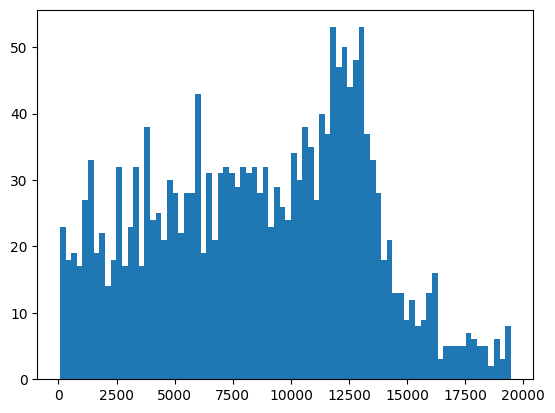

In [495]:
# histogram of all_lineups Ranks
plt.hist(all_lineups['Rank'], bins=80)

In [496]:
len(all_lineups)

1900

In [497]:
# how many in bad_lineups
len(bad_lineups)


187

In [498]:
len(great_lineups)

#great_lineups[2]

3

In [499]:
great_and_bad_lineups_hitters = pd.DataFrame()
great_and_bad_lineups_pitchers = pd.DataFrame()
great_and_bad_lineups = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(great_lineups)):
    # get each lineup individually
    this_lineup_avgs = great_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])

for i in range(len(bad_lineups)):
    # do the same but set great_lineup to 0
    this_lineup_avgs = bad_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['great_lineup'] = 0
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)

    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()

    great_and_bad_lineups_hitters = pd.concat([great_and_bad_lineups_hitters, this_lineup_avgs_hitters])
    great_and_bad_lineups_pitchers = pd.concat([great_and_bad_lineups_pitchers, this_lineup_avgs_pitchers])
    
    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={ 'great_lineup_pitcher': 'great_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['great_lineup'])
    great_and_bad_lineups = pd.concat([great_and_bad_lineups, all_lineup_data])


In [500]:
great_and_bad_lineups.head()

,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup,player_drafted_pred_pitcher,payoff_pred_pitcher,opp_mean_pred_pitcher,team_batter_fp_pred_pitcher,player_fp_pred_pitcher,WHIP_pitcher,est_woba_pitcher,est_slg_pitcher,hr_friendly_launch_speed_pitcher_pitcher,hr_friendly_launch_angle_pitcher_pitcher,batter_fp_pred_pitcher,pitcher_fp_pred_pitcher,team_batter_fp_pred_pitcher,team_batter_salary_pitcher,batter_drafted_pred_pitcher,pitcher_drafted_pred_pitcher,opp_pitcher_drafted_mean_pitcher,opp_batter_drafted_mean_pitcher,pitcher_payoff_pred_pitcher,Salary_pitcher,AvgPointsPerGame_pitcher
0,8.95,10.01,9.77,65.17,7.67,1.39,0.33,0.43,0.17,0.07,7.67,10.72,65.17,37812.50,8.95,12.90,11.30,8.83,5.86,4525.00,7.07,1.00,13.79,9.57,6.09,51.60,15.99,1.06,0.38,0.53,0.15,0.06,8.37,14.00,51.60,34600.00,6.89,10.28,13.79,6.59,9.50,6800.00,13.49
0,5.42,7.44,10.99,61.02,7.46,1.33,0.34,0.44,0.17,0.07,7.46,10.73,61.02,38200.00,5.42,13.00,13.46,5.94,4.40,4500.00,6.97,1.00,7.61,8.38,6.39,57.52,12.76,1.18,0.35,0.45,0.15,0.08,8.73,10.97,57.52,35550.00,5.50,5.60,7.61,6.87,6.99,6950.00,14.75
0,5.23,7.07,11.17,67.65,7.60,1.39,0.33,0.43,0.15,0.05,7.60,12.01,67.65,38525.00,5.23,10.30,9.11,5.22,4.33,4212.50,6.81,1.00,13.10,9.19,7.40,66.64,12.20,1.29,0.34,0.41,0.18,0.06,8.29,7.48,66.64,36550.00,0.56,10.43,13.10,4.38,3.24,8100.00,16.12
0,7.80,8.06,14.03,57.15,7.06,1.22,0.32,0.43,0.17,0.06,7.06,13.70,57.15,34925.00,7.80,17.14,17.73,7.01,7.81,4362.50,6.95,0.00,13.23,11.15,7.23,61.27,13.54,1.14,0.34,0.43,0.17,0.06,7.46,11.94,61.27,38450.00,4.38,10.42,13.23,6.81,6.79,7400.00,11.95
0,8.16,9.13,12.29,57.64,7.99,1.38,0.34,0.43,0.16,0.06,7.99,10.61,57.64,32200.00,8.16,14.23,17.20,8.02,7.93,4262.50,7.84,0.00,15.16,10.49,7.07,59.85,13.00,1.19,0.34,0.46,0.18,0.06,7.07,11.38,59.85,38100.00,5.13,12.31,15.16,7.05,6.70,7900.00,14.87


In [501]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 1]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,8.95,10.01,9.77,65.17,7.67,1.39,0.33,0.43,0.17,0.07,7.67,10.72,65.17,37812.50,8.95,12.90,11.30,8.83,5.86,4525.00,7.07,1.00
0,5.42,7.44,10.99,61.02,7.46,1.33,0.34,0.44,0.17,0.07,7.46,10.73,61.02,38200.00,5.42,13.00,13.46,5.94,4.40,4500.00,6.97,1.00
0,5.23,7.07,11.17,67.65,7.60,1.39,0.33,0.43,0.15,0.05,7.60,12.01,67.65,38525.00,5.23,10.30,9.11,5.22,4.33,4212.50,6.81,1.00


In [502]:
great_and_bad_lineups_hitters[great_and_bad_lineups_hitters['great_lineup'] == 0]


,player_drafted_pred,payoff_pred,opp_mean_pred,team_batter_fp_pred,player_fp_pred,WHIP,est_woba,est_slg,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,Salary,AvgPointsPerGame,great_lineup
0,7.80,8.06,14.03,57.15,7.06,1.22,0.32,0.43,0.17,0.06,7.06,13.70,57.15,34925.00,7.80,17.14,17.73,7.01,7.81,4362.50,6.95,0.00
0,8.16,9.13,12.29,57.64,7.99,1.38,0.34,0.43,0.16,0.06,7.99,10.61,57.64,32200.00,8.16,14.23,17.20,8.02,7.93,4262.50,7.84,0.00
0,9.66,9.16,11.30,61.44,7.75,1.41,0.34,0.43,0.16,0.07,7.75,10.36,61.44,35287.50,9.66,11.74,13.09,8.86,7.83,4387.50,7.23,0.00
0,10.99,11.02,6.91,70.64,8.79,1.73,0.31,0.39,0.15,0.09,8.79,5.99,70.64,34275.00,10.99,9.88,11.35,11.29,6.21,4250.00,7.40,0.00
0,3.36,9.88,8.20,70.60,8.08,1.46,0.35,0.46,0.18,0.07,8.08,8.22,70.60,40087.50,3.36,1.34,1.70,3.68,-1.28,4412.50,7.79,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,4.94,7.36,10.12,67.85,7.71,1.59,0.32,0.38,0.14,0.05,7.71,9.85,67.85,35125.00,4.94,10.57,11.66,5.52,4.38,4112.50,6.38,0.00
0,6.23,7.29,10.84,68.04,8.29,1.53,0.31,0.40,0.15,0.06,8.29,11.95,68.04,35175.00,6.23,12.12,10.56,5.77,4.91,4212.50,7.22,0.00
0,4.09,7.28,12.47,61.43,7.97,1.32,0.33,0.45,0.15,0.08,7.97,10.72,61.43,32425.00,4.09,9.49,12.64,5.46,5.00,4400.00,7.67,0.00
0,5.32,7.11,12.12,62.20,7.37,1.38,0.33,0.42,0.13,0.06,7.37,10.71,62.20,33875.00,5.32,8.58,11.39,5.55,5.45,4112.50,7.13,0.00


Feature: 0, Score: 0.01467
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.00000
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00000
Feature: 24, Score: 0.00000
Feature: 25, Score: 0.00000
Feature: 26, Score: 0.00000
Feature: 27, Score: 0.00000
Feature: 28, Score: 0.00000
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00000
Feature: 35, Score: 0.00000
Fe

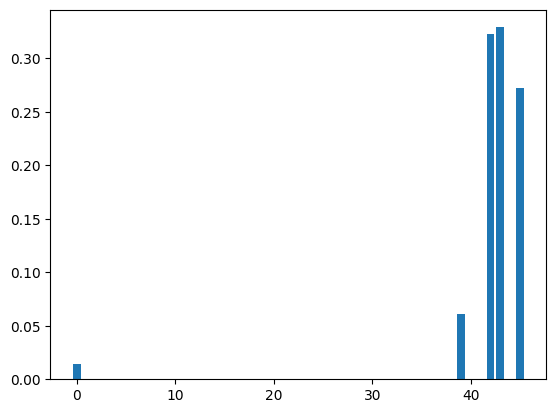

array([[38]], dtype=int64)

In [503]:
# commenting out 'great_lineup' prediction model since it does not seem to be working correctly

# create a model to predict if a lineup is a great lineup based on pregame factors
# # target is great_lineup, features are pregame factors
target = great_and_bad_lineups['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = great_and_bad_lineups.columns[great_and_bad_lineups.columns != 'great_lineup']
features = great_and_bad_lineups[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup = LinearRegression()

# # fit the model
# model_is_great_lineup.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup.predict(X_test)

# # calculate r2 and rmse
# r2 = r2_score(y_test, y_pred)
# rmse = sqrt(mean_squared_error(y_test, y_pred))

# print('Model R2: ', r2)
# print('Model RMSE: ', rmse)

# # importance of each feature
# importance = model_is_great_lineup.coef_
# # summarize feature importance
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# # plot feature importance
# plt.bar([x for x in range(len(importance))], importance)
# plt.show()

# do the above for a decision tree classifier model

# establish a model
model_is_great_lineup = DecisionTreeClassifier()

# fit the model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)
model_is_great_lineup.fit(X_train, y_train)
importance = model_is_great_lineup.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


y_pred = model_is_great_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)


In [504]:


# build a classification model to predict if a lineup is a great lineup
# # target is great_lineup, features are pregame factors
# target = great_and_bad_lineups_pitchers['great_lineup']
# # feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
# feature_names = [ 'opp_mean_pred', 'player_fp_pred', 'WHIP', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'payoff_pred', 'Salary']
# features = great_and_bad_lineups_pitchers[feature_names]
# # split the data
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# # establish a model
# model_is_great_lineup_pitchers = LogisticRegression()

# # fit the model
# model_is_great_lineup_pitchers.fit(X_train, y_train)

# # predict the model
# y_pred = model_is_great_lineup_pitchers.predict(X_test)

# confusion_matrix(y_test, y_pred)



In [505]:
lineups_hitters = pd.DataFrame()
lineups_pitchers = pd.DataFrame()
cashing_or_not = pd.DataFrame()
features = ['position', 'player_drafted_pred', 'payoff_pred', 'opp_mean_pred', 'team_batter_fp_pred', 'player_fp_pred', 'WHIP', 'est_woba', 'est_slg', 'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher', 'batter_fp_pred', 'pitcher_fp_pred', 'team_batter_fp_pred', 'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean', 'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame']

# find the difference between the great_lineups and bad_lineups
for i in range(len(cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 1
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])

for i in range(len(non_cashing_lineups)):
    # get each lineup individually
    this_lineup_avgs = non_cashing_lineups[i]
    this_lineup_avgs = this_lineup_avgs[features]
    
    # drop fpts and add great_lineup column = 1
    #this_lineup_avgs = this_lineup_avgs.drop('fpts')
    this_lineup_avgs['cashing_lineup'] = 0
    # split by hitters and pitchers
    this_lineup_avgs_hitters = this_lineup_avgs[this_lineup_avgs['position'] != 'P']
    this_lineup_avgs_pitchers = this_lineup_avgs[this_lineup_avgs['position'] == 'P']

    # drop position
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.drop(columns='position')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.drop(columns='position')

    # coerce to numeric
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.astype(float, errors='ignore')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.astype(float, errors='ignore')

    # get mean of numerics
    this_lineup_avgs_hitters = this_lineup_avgs_hitters.mean(numeric_only=True)
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.mean(numeric_only=True)
    # convert to dataframe
    this_lineup_avgs_hitters = pd.DataFrame(this_lineup_avgs_hitters).transpose()
    this_lineup_avgs_pitchers = pd.DataFrame(this_lineup_avgs_pitchers).transpose()
    # concat to great_and_bad_lineups
    lineups_hitters = pd.concat([lineups_hitters, this_lineup_avgs_hitters])
    lineups_pitchers = pd.concat([lineups_pitchers, this_lineup_avgs_pitchers])

    # add '_pitcher' to this_lineup_avgs_pitchers columns
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.add_suffix('_pitcher')
    this_lineup_avgs_pitchers = this_lineup_avgs_pitchers.rename(columns={'cashing_lineup_pitcher': 'cashing_lineup'})
    all_lineup_data = pd.merge(this_lineup_avgs_hitters, this_lineup_avgs_pitchers, on=['cashing_lineup'])
    cashing_or_not = pd.concat([cashing_or_not, all_lineup_data])



Feature: player_drafted_pred, Score: 0.02988
Feature: payoff_pred, Score: 0.03931
Feature: opp_mean_pred, Score: 0.05625
Feature: team_batter_fp_pred, Score: 0.00000
Feature: team_batter_fp_pred, Score: 0.02291
Feature: player_fp_pred, Score: 0.01863
Feature: WHIP, Score: 0.04209
Feature: est_woba, Score: 0.08388
Feature: est_slg, Score: 0.02499
Feature: hr_friendly_launch_speed_pitcher, Score: 0.04732
Feature: hr_friendly_launch_angle_pitcher, Score: 0.05094
Feature: batter_fp_pred, Score: 0.00945
Feature: pitcher_fp_pred, Score: 0.00110
Feature: team_batter_fp_pred, Score: 0.00392
Feature: team_batter_fp_pred, Score: 0.00000
Feature: team_batter_salary, Score: 0.03172
Feature: batter_drafted_pred, Score: 0.05966
Feature: pitcher_drafted_pred, Score: 0.02389
Feature: opp_pitcher_drafted_mean, Score: 0.04312
Feature: opp_batter_drafted_mean, Score: 0.03123
Feature: pitcher_payoff_pred, Score: 0.01944
Feature: Salary, Score: 0.03194
Feature: AvgPointsPerGame, Score: 0.02005
Feature: pla

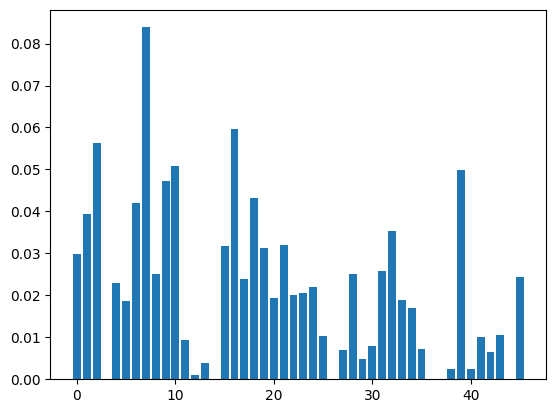

array([[245,  62],
       [ 38,  35]], dtype=int64)

In [506]:
# classification model to predict if a lineup is a cashing lineup
# target is cashing_lineup, features are pregame factors
target = cashing_or_not['cashing_lineup']
# feature_names are: avg_batter_fp	avg_batting_order	est_woba	est_slg	est_ba	hr_friendly_launch_speed_freq	hr_friendly_launch_angle_freq	Pitching+	WHIP	hr_friendly_launch_speed_pitcher	hr_friendly_launch_angle_pitcher	batting_order_change	batter_fp_pred	pitcher_fp_pred	team_batter_fp_pred	teams_in_game_pk	team_batter_salary	batter_drafted_pred	pitcher_drafted_pred	payoff_pred	opp_pitcher_drafted_mean	opp_batter_drafted_mean	pitcher_payoff_pred	ID	Salary	AvgPointsPerGame	player_fp_pred	player_drafted_pred	payoff	opp_mean_pred net_sqrt_pred Utility
feature_names = cashing_or_not.columns[cashing_or_not.columns != 'cashing_lineup']
features = cashing_or_not[feature_names]
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

# establish a model
model_is_cashing_lineup = DecisionTreeClassifier()

# fit the model
model_is_cashing_lineup.fit(X_train, y_train)
importance = model_is_cashing_lineup.feature_importances_
names = model_is_cashing_lineup.feature_names_in_

# summarize feature importance
for i,v in enumerate(importance):
    # print feature name
    print('Feature: %s, Score: %.5f' % (names[i],v))
    #print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# predict the model
y_pred = model_is_cashing_lineup.predict(X_test)
confusion_matrix(y_test, y_pred)

In [507]:
# change to True to run the following code
if False:
    best_lineup = pd.DataFrame()
    best_lineup_rank = 100000

    for i in range(150):
        lineup = build_one_lineup(all_variables)
        # get only variables for players with names in lineup_players
        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

        # add a dummy column to lineup_vars to groupby
        lineup_vars['Rank'] = 'dummy'

        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

        # rename pitcher columns by suffixing with '_pitcher'
        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

        # merge hitters and pitchers on Rank and Date
        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

        # drop Rank
        combined_vars = combined_vars.drop(columns='Rank')
        
        # get rank predictions
        lineup_rank_prediction = model.predict(combined_vars)
        lineup_rank_prediction = lineup_rank_prediction[0]

        if lineup_rank_prediction < best_lineup_rank:
            best_lineup = lineup

    best_lineup

In [508]:
### using the model to predict the rank of lineups built by build_one_lineup to filter best possible entries and backtest potential earnings had those been entered ###
# scrapped 5/26 as data was not correct and 6/2 as it was giving errors
lineups_to_build = 100
def backtest_with_models():
    files = get_files()

    # read model from 'C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav'
    model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))

    all_sum_fpts = []
    all_lineup_ranks = []
    all_lineup_payoffs = []
    #all_lineup_utilities = []
    all_lineup_rank_preds = []
    keepers = []
    # create a table for earnings per day
    earnings = pd.DataFrame()
    all_lineups = pd.DataFrame()

    for file in files:
        # proceed if file name is like 'MLBContestStandingsMMDDYYYY.csv' and 'DKSalariesMLBMMDDYYYY.csv'
        if 'MLBContestStandings' in file:
            date = file[-12:-4]
            m = str(date[0:2])
            d = str(date[2:4])
            y = str(date[4:8])
            # break if date is 06/02
            #if int(d) > 2 and int(m) == 6:
            if not (m == '06' and d == '02'):
                todays_lineups = pd.DataFrame(columns=['Date', 'Rank', 'Rank_pred', 'Payoff'])
                print('Getting data for ', m, d, y)
                contest_data = get_contest_standings(y, m, d)
                contest_player_results = get_contest_results(contest_data)
                leaderboard = get_leaderboard(contest_data)
                # skip if leaderboard has > 20000 rows or < 13000 rows
                if leaderboard.shape[0] < 20000 and leaderboard.shape[0] > 13000:
                    
                    # change 'Player' to 'Name' in contest_player_results
                    contest_player_results = contest_player_results.rename(columns={'Player': 'Name'})

                    # convert contest_player_results to a dictionary with 'Name' as key and 'FPTS' as value
                    contest_player_results = contest_player_results.set_index('Name')['FPTS'].to_dict()
                    
                    #someday will implement this rather than the below scripting, but for now keeping things as before
                    #build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
                    all_variables = get_all_variables(y, m, d, optional='', df=df)

                    payoff_total = 0
                    # max_fpts = 0
                    # max_lineup_rank = 100000
                    
                    # define an empty array to store lineups that rank > 14000
                    
                    # build lineups until lineups_to_build is reached
                    pbar = tqdm(desc="while loop", total=lineups_to_build)
                    i= 0
                    while i < lineups_to_build:
                        lineup = build_one_lineup(all_variables, all_variables)                        
                        # get only variables for players with names in lineup_players
                        lineup_vars = all_variables[(all_variables['Name']).isin(lineup['Name'])]

                        # add a dummy column to lineup_vars to groupby
                        lineup_vars['Rank'] = 'dummy'

                        lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
                        lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

                        lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
                        lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

                        # rename pitcher columns by suffixing with '_pitcher'
                        lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
                        lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

                        # merge hitters and pitchers on Rank and Date
                        combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

                        # drop Rank
                        rank_model_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order', 'est_woba',
                            'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
                            'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
                            'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
                            'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
                            'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
                            'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
                            'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
                            'pitcher_payoff_pred', 'Salary', 'AvgPointsPerGame',
                            'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
                            'batting_order_pitcher', 'avg_batter_fp_pitcher',
                            'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
                            'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
                            'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
                            'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
                            'hr_friendly_launch_angle_pitcher_pitcher',
                            'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
                            'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
                            'teams_in_game_pk_pitcher', 'is_of_pitcher',
                            'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
                            'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
                            'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
                            'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
                            'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
                            'player_drafted_pred_pitcher', 'payoff_pitcher',
                            'opp_mean_pred_pitcher']]
                        
                        # if combined_vars is empty, skip to next iteration
                        if rank_model_vars.empty:
                            continue

                        rank_model_vars = update_rank_model(rank_model_vars)
                        
                        great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
                        # get rank predictions
                        lineup_rank_prediction = model.predict(rank_model_vars)[0]
                        great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
                        cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

                        if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
                            continue
                        else:
                            # get actual fpts for lineup based on contest_player_results
                            lineup['fpts'] = lineup['Name'].map(contest_player_results)
                            lineup_fpts = lineup['fpts'].sum()

                            # get rank of lineup in leaderboard
                            lineup_rank = get_leaderboard_rank(leaderboard, lineup_fpts)
                            keepers.append(lineup)

                            # get payoff based on rank
                            this_payoff = get_payoff(lineup_rank)

                            # add current results to arrays
                            all_sum_fpts.append(lineup['player_fp_pred'].sum())
                            all_lineup_ranks.append(lineup_rank)
                            all_lineup_payoffs.append(this_payoff)
                            #all_lineup_utilities.append(lineup['Utility'].sum())
                            all_lineup_rank_preds.append(lineup_rank_prediction)

                            # add to todays_lineups
                            todays_lineups = pd.concat([todays_lineups, pd.DataFrame({'Date': [date], 'Rank': [lineup_rank], 'Rank_pred': [lineup_rank_prediction], 'Payoff': [this_payoff]})])
                            i = len(todays_lineups)

                        pbar.update(1)
                    pbar.close()
                    # get the payoff_total for all generated lineups
                    payoff_total_all = todays_lineups['Payoff'].sum()
                    
                    # add to all_lineups
                    all_lineups = pd.concat([all_lineups, todays_lineups])

                    # add to earnings table
                    timestamp = datetime.datetime.now().time()
                    earnings = pd.concat([earnings, pd.DataFrame({'Date': [date], 'GeneratedAt': [timestamp], 'Filtered Lineups Earnings': [payoff_total_all]})])

    return all_lineups, earnings, keepers

lineups, earnings, keepers = backtest_with_models()
earnings

Getting data for  05 23 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05232024.csv
Getting data for  05 24 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05242024.csv
Getting data for  05 25 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05252024.csv
Getting data for  05 27 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05272024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


Getting data for  05 28 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05282024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [02:24<00:00,  1.44s/it]


Getting data for  05 29 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05292024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [00:32<00:00,  3.03it/s]


Getting data for  05 30 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05302024.csv
Getting data for  05 31 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB05312024.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step


while loop: 100%|██████████| 100/100 [00:39<00:00,  2.53it/s]


Getting data for  06 03 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06032024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


Getting data for  06 04 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06042024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s]


Getting data for  06 05 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06052024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


Getting data for  06 06 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06062024.csv
Getting data for  06 07 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06072024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [01:39<00:00,  1.01it/s]


Getting data for  06 08 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06082024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step


while loop: 100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Getting data for  06 09 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06092024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:40<00:00,  2.48it/s]


Getting data for  06 10 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06102024.csv
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 100/100 [01:52<00:00,  1.13s/it]


Getting data for  06 11 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06112024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s]


Getting data for  06 12 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06122024.csv
Getting data for  06 13 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06132024.csv
Getting data for  06 14 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06142024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


while loop: 100%|██████████| 100/100 [00:40<00:00,  2.45it/s]


Getting data for  06 15 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06152024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:50<00:00,  1.98it/s]


Getting data for  06 16 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06162024.csv
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step


while loop: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


Getting data for  06 17 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06172024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [00:34<00:00,  2.90it/s]


Getting data for  06 18 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06182024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Getting data for  06 19 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06192024.csv
Getting data for  06 20 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06202024.csv
Getting data for  06 21 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06212024.csv
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


while loop: 100%|██████████| 100/100 [02:26<00:00,  1.47s/it]


Getting data for  06 22 2024
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\MLBContestStandings06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06222024.csv
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step


while loop: 100%|██████████| 100/100 [01:19<00:00,  1.26it/s]


,Date,GeneratedAt,Filtered Lineups Earnings
0,05272024,17:43:03.585894,-235
0,05282024,17:46:13.597347,-400
0,05292024,17:47:32.974329,-310
0,05312024,17:48:59.578692,200
0,06032024,17:50:31.841871,3000
0,06042024,17:52:25.480119,-525
0,06052024,17:54:14.949573,-1135
0,06072024,17:56:45.730593,-780
0,06082024,17:58:07.021920,-1110
0,06092024,17:59:39.258962,5920


In [509]:
# get pct earnings for each day
pct_earnings = earnings.copy()
pct_earnings['Filtered Lineups Earnings'] = pct_earnings['Filtered Lineups Earnings'].astype(float)/(lineups_to_build*15)*100
print("Sum filtered lineups earnings: ", pct_earnings['Filtered Lineups Earnings'].sum())

Sum filtered lineups earnings:  90.66666666666671


In [510]:
len(keepers)/len(lineups) * 100 # percentage of lineups kept

100.0

In [511]:
# get all variables - refreshes default data before building

# programatically get the date
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

# optional = ''

# pregame_data = get_pregame_info(df, year, month, day)
# all_players_plus_data = get_todays_data(year, month, day, optional=optional, pregame_data=pregame_data, df=df)

# all_variables = get_all_variables(year, month, day, optional='', df=df)

In [512]:
# save models to disk
pickle.dump(model_is_great_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'wb'))
pickle.dump(model_is_cashing_lineup, open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'wb'))

In [513]:
# display floats to 1 decimal
pd.options.display.float_format = '{:.3f}'.format
all_variables[(all_variables['team'] == 'CIN')].sort_values(by='player_fp_pred', ascending=False)


,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value
47,Frankie Montas,9.000,SS/OF,6.575,8.343,0.260,0.350,0.220,0.120,0.080,100.000,1.390,0.187,0.056,-0.657,6.960,15.076,67.093,15.000,1.000,35400.000,3.766,16.273,10.522,8.979,6.959,5.748,ceddanne rafaela,frankie montas,SP,Frankie Montas (34733554),34733554,P,6000,BOS@CIN 06/22/2024 04:10PM ET,CIN,10.070,frankie montas,10.933,8.979,5.748,BOS,7.455,1.822
63,Jeimer Candelario,2.000,1B/3B,8.060,4.561,0.305,0.409,0.236,0.131,0.055,110.000,1.130,0.145,0.093,2.561,7.540,17.064,48.168,15.000,1.000,32200.000,6.794,25.273,5.687,24.659,4.813,7.298,jeimer candelario,nick pivetta,1B/3B,Jeimer Candelario (34733613),34733613,1B/3B,4200,BOS@CIN 06/22/2024 04:10PM ET,CIN,7.810,jeimer candelario,7.540,6.794,5.687,BOS,16.716,1.795
124,Spencer Steer,3.000,1B,7.603,3.708,0.335,0.426,0.251,0.139,0.079,110.000,1.130,0.145,0.093,0.708,7.360,14.518,48.168,15.000,0.000,32200.000,5.904,20.790,5.752,24.659,4.813,7.298,spencer steer,nick pivetta,1B,Spencer Steer (34733587),34733587,1B,4600,BOS@CIN 06/22/2024 04:10PM ET,CIN,7.710,spencer steer,7.360,5.904,5.752,BOS,16.716,1.600
42,Elly De La Cruz,1.000,SS,7.293,3.189,0.331,0.431,0.230,0.168,0.047,110.000,1.130,0.145,0.093,2.189,7.121,16.567,48.168,15.000,0.000,32200.000,8.178,24.398,5.407,24.659,4.813,7.298,elly de la cruz,nick pivetta,SS,Elly De La Cruz (34733560),34733560,SS,6200,BOS@CIN 06/22/2024 04:10PM ET,CIN,9.840,elly de la cruz,7.121,8.178,5.407,BOS,16.716,1.149
70,Jonathan India,5.000,2B,6.618,4.676,0.343,0.377,0.276,0.120,0.062,110.000,1.130,0.145,0.093,-0.324,6.533,11.114,48.168,15.000,0.000,32200.000,4.066,14.798,5.835,24.659,4.813,7.298,jonathan india,nick pivetta,2B,Jonathan India (34733667),34733667,2B,3500,BOS@CIN 06/22/2024 04:10PM ET,CIN,6.620,jonathan india,6.533,4.066,5.835,BOS,16.716,1.867
107,Nick Martini,6.000,OF,5.816,6.794,0.266,0.336,0.211,0.105,0.075,110.000,1.130,0.145,0.093,0.794,5.538,19.898,48.168,15.000,1.000,32200.000,3.505,30.262,5.655,24.659,4.813,7.298,nick martini,nick pivetta,OF,Nick Martini (34733644),34733644,OF,3700,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.220,nick martini,5.538,3.505,5.655,BOS,16.716,1.497
136,Will Benson,8.000,OF,5.457,5.613,0.285,0.353,0.195,0.134,0.046,110.000,1.130,0.145,0.093,-2.387,5.423,20.516,48.168,15.000,1.000,32200.000,2.189,31.349,6.203,24.659,4.813,7.298,will benson,nick pivetta,OF,Will Benson (34733694),34733694,OF,3200,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.660,will benson,5.423,2.189,6.203,BOS,16.716,1.695
57,Jake Fraley,4.000,OF,4.386,4.979,0.288,0.322,0.251,0.098,0.067,110.000,1.130,0.145,0.093,0.979,4.418,15.138,48.168,15.000,1.000,32200.000,4.122,21.883,5.254,24.659,4.813,7.298,jake fraley,nick pivetta,OF,Jake Fraley (34733623),34733623,OF,4100,BOS@CIN 06/22/2024 04:10PM ET,CIN,5.460,jake fraley,4.418,4.122,5.254,BOS,16.716,1.077
91,Luke Maile,7.000,C,4.061,8.586,0.287,0.312,0.204,0.072,0.072,110.000,1.130,0.145,0.093,1.586,4.235,18.909,48.168,15.000,0.000,32200.000,3.745,28.521,5.675,24.659,4.813,7.298,luke maile,nick pivetta,C,Luke Maile (34733741),34733741,C,2700,BOS@CIN 06/22/2024 04:10PM ET,CIN,3.880,luke maile,4.235,3.745,5.675,BOS,16.716,1.569


Mass Multi Entry Builder

In [520]:

# build a csv of dk lineups using get_best_lineup
todays_date = get_todays_date()
year =  todays_date.split('-')[0]
month = todays_date.split('-')[1]
day = todays_date.split('-')[2]

# Number of lineups at the end
lineups_to_build = 20
# Number of lineups to build, of which we select the best ranked lineups_to_build
# iterations = 200
# banned players by name
bans = []
# Max percent of lineups that should include a single player
# max_own_goal = 0.7
# sets the standard deviation for the normal distribution used to select players
stdev = 9

# year, month day, optional and df are all defined above
optional = 'b'
# def build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df):
# get all variables - refreshes default data before building

all_variables = get_all_variables(year, month, day, optional, df=df)
all_variables['ID'] = all_variables['ID'].astype(str)
# bans = ['William Contreras', 'Connor Wong', 'Jose Trevino', 'TB', 'MIN']

# all_variables = all_variables[~all_variables['Name'].isin(bans)]
# all_variables = all_variables[~all_variables['team'].isin(bans)]

temp_col_names = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', 'Rank_pred', 'key']
column_names = ['P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
lineups = pd.DataFrame(columns=temp_col_names)
model = pickle.load(open('C:\\Users\\jorda\\Downloads\\pregame_rank_model.sav', 'rb'))
model_is_cashing_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_cashing_lineup.sav', 'rb'))
model_is_great_lineup = pickle.load(open('C:\\Users\\jorda\\Downloads\\model_is_great_lineup.sav', 'rb'))

# # create a dictionary to store number of times each id is in a lineup
# id_counts = dict.fromkeys(all_variables['ID'], 0)
# # get max number of times a player can be in a lineup
# max_id_count = int(lineups_to_build * max_own_goal)

pbar = tqdm(total=lineups_to_build, desc="while loop")
i = 0
counter = 0
while i < lineups_to_build:
    # add progress bar to loop with tqdm
    counter += 1
    lineup_vars = build_one_lineup(all_variables, all_variables, bans=bans, stdev=stdev)
    
    for col in lineup_vars.columns:
        if col == 'ID':
            continue
        try:
            lineup_vars[col] = lineup_vars[col].astype(float)
        except:
            continue        
    # add a dummy column to lineup_vars to groupby
    lineup_vars['Rank'] = 'dummy'

    lineup_hitters = lineup_vars[lineup_vars['position'] != 'P']
    lineup_pitchers = lineup_vars[lineup_vars['position'] == 'P']

    lineup_hitters = lineup_hitters.groupby(['Rank']).mean(numeric_only=True).reset_index()
    lineup_pitchers = lineup_pitchers.groupby(['Rank']).mean(numeric_only=True).reset_index()

    # rename pitcher columns by suffixing with '_pitcher'
    lineup_pitchers = lineup_pitchers.add_suffix('_pitcher')
    lineup_pitchers = lineup_pitchers.rename(columns={'Rank_pitcher': 'Rank'})

    # merge hitters and pitchers on Rank and Date
    combined_vars = pd.merge(lineup_hitters, lineup_pitchers, on=['Rank'])

    # drop Rank
    combined_vars = combined_vars.drop(columns=['Rank'])

    combined_vars = update_rank_model(combined_vars)
    rank_model_vars = combined_vars[['batting_order', 'avg_batter_fp', 'avg_batting_order',
    'est_woba', 'est_slg', 'est_ba', 'hr_friendly_launch_speed_freq',
    'hr_friendly_launch_angle_freq', 'Pitching+', 'WHIP',
    'hr_friendly_launch_speed_pitcher', 'hr_friendly_launch_angle_pitcher',
    'batting_order_change', 'batter_fp_pred', 'pitcher_fp_pred',
    'team_batter_fp_pred', 'teams_in_game_pk', 'is_of',
    'team_batter_salary', 'batter_drafted_pred', 'pitcher_drafted_pred',
    'payoff_pred', 'opp_pitcher_drafted_mean', 'opp_batter_drafted_mean',
    'pitcher_payoff_pred',  'Salary', 'AvgPointsPerGame',
    'player_fp_pred', 'player_drafted_pred', 'payoff', 'opp_mean_pred',
    'batting_order_pitcher', 'avg_batter_fp_pitcher',
    'avg_batting_order_pitcher', 'est_woba_pitcher', 'est_slg_pitcher',
    'est_ba_pitcher', 'hr_friendly_launch_speed_freq_pitcher',
    'hr_friendly_launch_angle_freq_pitcher', 'Pitching+_pitcher',
    'WHIP_pitcher', 'hr_friendly_launch_speed_pitcher_pitcher',
    'hr_friendly_launch_angle_pitcher_pitcher',
    'batting_order_change_pitcher', 'batter_fp_pred_pitcher',
    'pitcher_fp_pred_pitcher', 'team_batter_fp_pred_pitcher',
    'teams_in_game_pk_pitcher', 'is_of_pitcher',
    'team_batter_salary_pitcher', 'batter_drafted_pred_pitcher',
    'pitcher_drafted_pred_pitcher', 'payoff_pred_pitcher',
    'opp_pitcher_drafted_mean_pitcher', 'opp_batter_drafted_mean_pitcher',
    'pitcher_payoff_pred_pitcher', 'Salary_pitcher',
    'AvgPointsPerGame_pitcher', 'player_fp_pred_pitcher',
    'player_drafted_pred_pitcher', 'payoff_pitcher',
    'opp_mean_pred_pitcher', 'total_fp_pred', 'drafted_product',
    'total_net_sqrt_pred']]

    great_lineup_vars = combined_vars[model_is_cashing_lineup.feature_names_in_]
    # get rank predictions
    lineup_rank_prediction = model.predict(rank_model_vars)[0]
    great_lineup_prediction = model_is_great_lineup.predict(great_lineup_vars)[0]
    cashing_lineup_prediction = model_is_cashing_lineup.predict(great_lineup_vars)[0]

    if great_lineup_prediction == 0 and cashing_lineup_prediction == 0:
         continue
    else:
        # alphabetize IDs, concatenate as single string, add to lineup as key
        alphabetized_ids = lineup_vars['ID'].astype(str).sort_values().tolist()
        alphabetized_ids = ''.join(alphabetized_ids)

        # add lineup prediction to lineup ids
        ids = lineup_vars['ID'].tolist()

        ids.append(lineup_rank_prediction)
        ids.append(alphabetized_ids)
        pre = len(lineups)
        lineups = pd.concat([lineups, pd.DataFrame([ids], columns=temp_col_names)])
        # drop duplicates
        lineups = lineups.drop_duplicates(subset='key') 
        i = len(lineups)
        if i > pre:
            pbar.update(1)
pbar.close()

# # get the best 'lineups_to_build' lineups based on rank prediction
# lineups = lineups.sort_values(by='Rank_pred').head(lineups_to_build)

# get lineup ids
lineups = lineups.drop(columns=['Rank_pred', 'key'])

# rename columns
lineups.columns = column_names
# return lineups

# lineups = build_my_lineups(lineups_to_build, iterations, bans, max_own_goal, stdev, year, month, day, optional='', df=df)
# save lineups to csv
lineups.to_csv('C:\\Users\\jorda\\Downloads\\lineups.csv', index=False)

C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06272024b.csv
C:\Users\jorda\OneDrive\Desktop\DFS History\MLB\DKSalariesMLB06272024b.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


while loop: 100%|██████████| 20/20 [00:03<00:00,  5.08it/s]


In [515]:

print('Great lineup prediction: ', great_lineup_prediction, '\nCashing lineup prediction: ', cashing_lineup_prediction, '\nLineups for export: ', len(lineups), '\nLineups built: ', counter)


Great lineup prediction:  0.0 
Cashing lineup prediction:  1.0 
Lineups for export:  20 
Lineups built:  126


In [516]:
def write_to_entries():
    # import from DKEntriesMLB.csv
    # use columns  0 - 16
    entries = pd.read_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', sep=",", header=0, names=range(14), usecols=range(14))
    # change column names to original
    entries = entries.drop(columns=range(4, 14))
   
    # replace columns 4-13 with IDs from 'C:\\Users\\jorda\\Downloads\\lineups.csv'
    new_lineups = pd.read_csv('C:\\Users\\jorda\\Downloads\\lineups.csv')
    # make new_lineups all strings
    new_lineups = new_lineups.astype(str)
    entries = entries.astype(str)
    entries = pd.concat([entries, new_lineups], axis=1)
    # remove NaNs
    entries.columns = ['Entry ID', 'Contest Name', 'Contest ID', 'Entry Fee', 'P', 'P', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF', 'OF']
    entries = entries.dropna()
     # remove decimals from first column if there is a decimal
    entries.replace('\.0', '', regex=True, inplace=True)

    # remove scientific notation
    pd.options.display.float_format = '{:.0f}'.format
    # write to csv, do not include index
    entries.to_csv('C:\\Users\\jorda\\Downloads\\DKEntriesMLB.csv', index=False)
    return entries
entries = write_to_entries()

In [521]:
def check_ownership(lineups, top_own = 20):
    num_built = lineups.shape[0]
    # check number of times each player is in lineups and sort by most to least
    ownership = lineups.stack().value_counts().reset_index()
    ownership = ownership.rename(columns={'index': 'ID', 0: 'count'})
    ownership = ownership.sort_values(by='count', ascending=False)
    ownership = pd.merge(ownership, all_variables[['ID', 'Name', 'team', 'position']], on='ID')
    # calculate percentage of lineups each player is in, rounded to 2 decimal places
    ownership['percentage'] = (ownership['count'] / num_built) * 100
    print(ownership.head(top_own))

check_ownership(lineups, top_own=40)


          ID  count                Name team position  percentage
0   34801298     11       Michael Wacha   KC        P          55
1   34801336      8          Masyn Winn  STL       SS          40
2   34801295      8       Andrew Abbott  CIN        P          40
3   34801296      7        Jose Berrios  TOR        P          35
4   34801305      6         Steven Kwan  CLE       OF          30
5   34801333      6     Davis Schneider  TOR    2B/OF          30
6   34801311      6   Willson Contreras  STL        C          30
7   34801301      6          Bobby Witt   KC       SS          30
8   34801302      6           Juan Soto  NYY       OF          30
9   34801297      6       Miles Mikolas  STL        P          30
10  34801300      5         Aaron Judge  NYY       OF          25
11  34801313      5       Maikel Garcia   KC    2B/3B          25
12  34801383      5       Gabriel Arias  CLE    3B/SS          25
13  34801306      5           David Fry  CLE     C/OF          25
14  348012

In [518]:
all_variables[all_variables['team'] == "ATL"]

,Name,batting_order,Roster Position_x,avg_batter_fp,avg_batting_order,est_woba,est_slg,est_ba,hr_friendly_launch_speed_freq,hr_friendly_launch_angle_freq,Pitching+,WHIP,hr_friendly_launch_speed_pitcher,hr_friendly_launch_angle_pitcher,batting_order_change,batter_fp_pred,pitcher_fp_pred,team_batter_fp_pred,teams_in_game_pk,is_of,team_batter_salary,batter_drafted_pred,pitcher_drafted_pred,payoff_pred,opp_pitcher_drafted_mean,opp_batter_drafted_mean,pitcher_payoff_pred,batter_name_lower,pitcher_name_lower,Position,Name + ID,ID,position,Salary,Game Info,team,AvgPointsPerGame,Name_lower,player_fp_pred,player_drafted_pred,payoff,opp_team,opp_mean_pred,value
